In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import math
import time



In [2]:
def runExp(seed, selectedCols, datafile):
    torch.manual_seed(seed)
    inputDim = len(selectedCols)
    numRandom = 13-inputDim
    randT = torch.rand((2063, numRandom))
    class FeatureDataset(Dataset):
        def __init__(self, filename):
            file_out = pd.read_csv(filename)
#             file_out = file_out[((file_out['sale']<file_out['sale'].quantile(0.97)) & (file_out['sale']>file_out['sale'].quantile(0.05)))]
            print(file_out.std())
            file_out=(file_out-file_out.min())/(file_out.max()-file_out.min())
#             print(file_out.max())
#             print(file_out.min())
            0/0
            
#             0/0
            x = file_out[selectedCols].values
            y = file_out[['sale']].values

            self.x_train = torch.cat((torch.tensor(x, dtype=torch.float32),randT),1)
            self.y_train = torch.tensor(y, dtype=torch.float32)

        def __len__(self):
            return len(self.y_train)
        def __getitem__(self, idx):
            return self.x_train[idx], self.y_train[idx]
        
    train_dataset = FeatureDataset(datafile)
    train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, 
                                                                 [int(len(train_dataset)*0.9)+1, int(len(train_dataset)*0.1)], 
                                                                 generator=torch.Generator().manual_seed(42))
    
    model = nn.Sequential(
        # For fully-connected networks, we don't use the 2D structure of an image at all. Our network
        # takes in a flat vector of the pixel values as input.
        nn.Linear(13, 100),
        nn.ReLU(),
        nn.Linear(100, 500),
        nn.ReLU(),
        nn.Linear(500, 500),
        nn.ReLU(),
        nn.Linear(500, 10),
        nn.ReLU(),
        nn.Linear(10, 1)
    )
    
    count = 0
    for p in model.parameters():
        n_params = np.prod(list(p.data.shape)).item()
        count += n_params
#     print(f'total params: {count}')
    
    def run_training_loop(model, batch_size=32, n_epochs=10, lr=1e-3):

        # We could write our training procedure manually and directly index the `Dataset` objects,
        # but the `DataLoader` object conveniently creates an iterable for automatically creating random minibatches:
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

        # Choose Adam as the optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # Use the cross entropy loss function
        loss_fn = nn.MSELoss(reduction = 'sum')

        # store metrics
        train_loss_history = np.zeros([n_epochs, 1])
        valid_accuracy_history = np.zeros([n_epochs, 1])
        valid_loss_history = np.zeros([n_epochs, 1])

        for epoch in range(n_epochs):
            


            # Some layers, such as Dropout, behave differently during training
            model.train()

            train_loss = 0
            for batch_idx, (data, target) in enumerate(train_loader):
                # Erase accumulated gradients
                optimizer.zero_grad()

                # Forward pass
                output = model(data)

                # Calculate loss
                loss = loss_fn(output, target)
                train_loss += loss.item()

                # Backward pass
                loss.backward()

                # Weight update
                optimizer.step()

            train_loss_history[epoch] = train_loss / len(train_loader.dataset)

            # Track loss each epoch
#             print('Train Epoch: %d  Average loss: %.4f' %
#                   (epoch + 1,  train_loss_history[epoch]))

            # Putting layers like Dropout into evaluation mode
            model.eval()

            valid_loss = 0

            # Turning off automatic differentiation
            with torch.no_grad():
                for data, target in valid_loader:
                    output = model(data)
                    valid_loss += loss_fn(output, target).item()  # Sum up batch loss

            valid_loss_history[epoch] = valid_loss/ len(valid_loader.dataset)

#             print('Valid set: Average loss: %.7f\n' %
#                   (valid_loss_history[epoch]))

        return model, train_loss_history, valid_loss_history, valid_accuracy_history
    
    m, t, v, va = run_training_loop(model, batch_size=512, n_epochs=50, lr=1e-3)
    
    m, t, v2, va = run_training_loop(model, batch_size=512, n_epochs=50, lr=1e-5)
    
    return math.sqrt(min(min(v).item(), min(v2).item()))*(8.88-0.047)

In [6]:
datafile = 'PPGMLFeature.csv'
for selectedCols in [['median'], ['pSale'], ['sPR', 'bPR', 'sDG', 'bDG'], ['flag', 'sumFlag'], ['median', 'pSale', 'sPR', 'bPR', 'sDG', 'bDG'], ['median', 'pSale', 'sPR', 'bPR', 'sDG', 'bDG', 'flag', 'sumFlag'], ['median', 'pSale'], ['median', 'pSale', 'flag', 'sumFlag']]:
    print(selectedCols)
    for seed in range(10):
        o = runExp(seed, selectedCols, datafile)
        print(o)

['median']
pSale            0.276307
bPR              0.000563
sPR              0.000332
bDG             33.647279
sDG             32.975520
positional       0.707379
median           1.951735
flag             0.051334
sumFlag          1.818240
tokenId       2555.695517
sale             3.167195
dtype: float64


ZeroDivisionError: division by zero

In [80]:

def runExpLSTM(seed, selectedCols, datafile, seLen):
    torch.manual_seed(seed)
    inputDim = len(selectedCols)
    numRandom = 13-inputDim
    randT = torch.rand((2063, numRandom))
    
    
    class SequenceDataset(Dataset):
        def __init__(self, datafile, target, features, sequence_length=5):
            dataframe = pd.read_csv(datafile)
#             dataframe = dataframe[((dataframe['sale']<dataframe['sale'].quantile(0.97)) & (dataframe['sale']>dataframe['sale'].quantile(0.05)))]
            dataframe=(dataframe-dataframe.min())/(dataframe.max()-dataframe.min())
            self.features = features
            self.target = target
            self.sequence_length = sequence_length
            self.y = torch.tensor(dataframe[target].values).float()
            self.X = torch.cat((torch.tensor(dataframe[features].values).float(), randT), 1)
            x = []
            for i in range(self.X.shape[0] - (self.sequence_length - 1)):
                x.append(self.X[i:(i + self.sequence_length), :])
            self.X = x
            self.y = self.y[self.sequence_length-1:]

        def __len__(self):
            return len(self.X)

        def __getitem__(self, i): 
            return self.X[i], self.y[i]
    
    
    train_dataset = SequenceDataset(datafile, 'sale', selectedCols, sequence_length = seLen)
    train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, 
                                                                 [int(len(train_dataset)*0.9)+1, int(len(train_dataset)*0.1)], 
                                                                 generator=torch.Generator().manual_seed(42))
    
    class ShallowRegressionLSTM(nn.Module):
        def __init__(self, num_sensors, hidden_units):
            super().__init__()
            self.num_sensors = num_sensors  # this is the number of features
            self.hidden_units = hidden_units
            self.num_layers = 1

            self.lstm = nn.LSTM(
                input_size=num_sensors,
                hidden_size=hidden_units,
                batch_first=True,
                num_layers=self.num_layers
            )

            self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

        def forward(self, x):
            batch_size = x.shape[0]
            h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
            c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

            _, (hn, _) = self.lstm(x, (h0, c0))
            out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

            return out
    
    model = ShallowRegressionLSTM(13, 16)
    
    count = 0
    for p in model.parameters():
        n_params = np.prod(list(p.data.shape)).item()
        count += n_params
#     print(f'total params: {count}')
    
    def run_training_loop(model, batch_size=32, n_epochs=10, lr=1e-3):

        # We could write our training procedure manually and directly index the `Dataset` objects,
        # but the `DataLoader` object conveniently creates an iterable for automatically creating random minibatches:
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

        # Choose Adam as the optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # Use the cross entropy loss function
        loss_fn = nn.MSELoss(reduction = 'sum')

        # store metrics
        train_loss_history = np.zeros([n_epochs, 1])
        valid_accuracy_history = np.zeros([n_epochs, 1])
        valid_loss_history = np.zeros([n_epochs, 1])

        for epoch in range(n_epochs):
            

            # Some layers, such as Dropout, behave differently during training
            model.train()

            train_loss = 0
            for batch_idx, (data, target) in enumerate(train_loader):
                # Erase accumulated gradients
                optimizer.zero_grad()

                # Forward pass
                output = model(data)

                # Calculate loss
                loss = loss_fn(output, target)
                train_loss += loss.item()

                # Backward pass
                loss.backward()

                # Weight update
                optimizer.step()

            train_loss_history[epoch] = train_loss / len(train_loader.dataset)

            # Track loss each epoch
#             print('Train Epoch: %d  Average loss: %.4f' %
#                   (epoch + 1,  train_loss_history[epoch]))

            # Putting layers like Dropout into evaluation mode
            model.eval()

            valid_loss = 0

            # Turning off automatic differentiation
            with torch.no_grad():
                for data, target in valid_loader:
                    output = model(data)
                    valid_loss += loss_fn(output, target).item()  # Sum up batch loss

            valid_loss_history[epoch] = valid_loss/ len(valid_loader.dataset)

#             print('Valid set: Average loss: %.7f\n' %
#                   (valid_loss_history[epoch]))
            

        return model, train_loss_history, valid_loss_history, valid_accuracy_history
    
    m, t, v, va = run_training_loop(model, batch_size=512, n_epochs=25, lr=1e-3)
    
    m, t, v2, va = run_training_loop(model, batch_size=512, n_epochs=25, lr=1e-5)
    
    return math.sqrt(min(min(v).item(), min(v2).item()))*(8.88-0.047)

In [81]:
datafile = 'IRENEDAOMLFeature.csv'
for selectedCols in [['median'], ['pSale'], ['sPR', 'bPR', 'sDG', 'bDG'], ['flag', 'sumFlag'], ['median', 'pSale', 'sPR', 'bPR', 'sDG', 'bDG'], ['median', 'pSale', 'sPR', 'bPR', 'sDG', 'bDG', 'flag', 'sumFlag'], ['median', 'pSale'], ['median', 'pSale', 'flag', 'sumFlag']]:
    print(selectedCols)
    for seed in range(10):
        o = runExpLSTM(seed, selectedCols, datafile, 200)
        print(o)

['median']
0.7537825978700653
0.40617204311164157
0.8785858591918555
0.4258421180227334
0.5291681615678405
0.7103750931071318
0.4374790918433899
0.4384357734553418
0.5648553475871895
0.45511584963367885
['pSale']
0.8689073389212225
0.820007146614489
0.9290960017825475
0.7386270260583058
0.8304576163038584
0.9223061954904691
0.7959042401591209
0.814570732461686
0.8577785751933467
0.84572913684156
['sPR', 'bPR', 'sDG', 'bDG']
0.7423211791275528
0.7461184560986157
0.9326494758712741
0.8158621449816033
0.5088609844705132
0.9578277112842348
0.9401225187108814
0.8365912557709199
0.9438988635517368
0.9525053299211531
['flag', 'sumFlag']
0.8569726047445956
0.7734592571280059
0.7848638143131146
0.8366968967210114
0.8802179276821995
0.8411929353615134
0.908365815964284
0.8725201690464713
0.9029542188434156
0.8326171467818089
['median', 'pSale', 'sPR', 'bPR', 'sDG', 'bDG']
0.3560885178953231
0.48470964704875746
0.3923781467128773
0.4775256514587591
0.41474499430032935
0.6431286483010629
0.8233697

In [ ]:
datafile = 'COOLSMLFeatureImages12.csv'
for selectedCols in [['median', 'pSale'], ['median', 'pSale', 'bPR', 'sPR', 'bDG', 'sDG'], ['median', 'pSale', 'flag', 'sumFlag'], ['median', 'pSale', 'image0', 'image1', 'image2', 'image3', 'image4'], ['bPR', 'sPR', 'bDG', 'sDG'], ['flag', 'sumFlag'], ['bPR', 'sPR', 'bDG', 'sDG', 'flag', 'sumFlag', 'pSale'], ['median'], ['image0', 'image1', 'image2', 'image3', 'image4'], ['bPR', 'sPR', 'bDG', 'sDG', 'flag', 'sumFlag'], ['median', 'pSale', 'bPR', 'sPR', 'bDG', 'sDG', 'flag', 'sumFlag', 'image0', 'image1', 'image2', 'image3', 'image4']]:
    print(selectedCols)
    for seed in range(10):
        o = runExpLSTM(seed, selectedCols, datafile, 200)
        print(seed, ':', o)

In [ ]:
datafile = 'COOLSMLFeatureImages6.csv'
for selectedCols in [['median', 'pSale'], ['median', 'pSale', 'bPR', 'sPR', 'bDG', 'sDG'], ['median', 'pSale', 'flag', 'sumFlag'], ['median', 'pSale', 'image0', 'image1', 'image2', 'image3', 'image4'], ['bPR', 'sPR', 'bDG', 'sDG'], ['flag', 'sumFlag'], ['bPR', 'sPR', 'bDG', 'sDG', 'flag', 'sumFlag', 'pSale'], ['median'], ['image0', 'image1', 'image2', 'image3', 'image4'], ['bPR', 'sPR', 'bDG', 'sDG', 'flag', 'sumFlag'], ['median', 'pSale', 'bPR', 'sPR', 'bDG', 'sDG', 'flag', 'sumFlag', 'image0', 'image1', 'image2', 'image3', 'image4']]:
    print(selectedCols)
    for seed in range(10):
        o = runExpLSTM(seed, selectedCols, datafile, 200)
        print(seed, ':', o)

In [817]:
m, t, v, va = run_training_loop(model, batch_size=512, n_epochs=50, lr=1e-3)

Train Epoch: 1  Average loss: 0.0191
Valid set: Average loss: 0.0080543

Train Epoch: 2  Average loss: 0.0079
Valid set: Average loss: 0.0073143

Train Epoch: 3  Average loss: 0.0077
Valid set: Average loss: 0.0074147

Train Epoch: 4  Average loss: 0.0077
Valid set: Average loss: 0.0088183

Train Epoch: 5  Average loss: 0.0078
Valid set: Average loss: 0.0071217

Train Epoch: 6  Average loss: 0.0073
Valid set: Average loss: 0.0074840

Train Epoch: 7  Average loss: 0.0072
Valid set: Average loss: 0.0076193

Train Epoch: 8  Average loss: 0.0074
Valid set: Average loss: 0.0071385

Train Epoch: 9  Average loss: 0.0072
Valid set: Average loss: 0.0075785

Train Epoch: 10  Average loss: 0.0072
Valid set: Average loss: 0.0071918

Train Epoch: 11  Average loss: 0.0070
Valid set: Average loss: 0.0072357

Train Epoch: 12  Average loss: 0.0070
Valid set: Average loss: 0.0071028

Train Epoch: 13  Average loss: 0.0070
Valid set: Average loss: 0.0070005

Train Epoch: 14  Average loss: 0.0069
Valid set

In [818]:
m, t, v2, va = run_training_loop(model, batch_size=512, n_epochs=50, lr=1e-5)

Train Epoch: 1  Average loss: 0.0034
Valid set: Average loss: 0.0074005

Train Epoch: 2  Average loss: 0.0032
Valid set: Average loss: 0.0073683

Train Epoch: 3  Average loss: 0.0032
Valid set: Average loss: 0.0073176

Train Epoch: 4  Average loss: 0.0032
Valid set: Average loss: 0.0073416

Train Epoch: 5  Average loss: 0.0031
Valid set: Average loss: 0.0073472

Train Epoch: 6  Average loss: 0.0031
Valid set: Average loss: 0.0073214

Train Epoch: 7  Average loss: 0.0031
Valid set: Average loss: 0.0073357

Train Epoch: 8  Average loss: 0.0031
Valid set: Average loss: 0.0073633

Train Epoch: 9  Average loss: 0.0031
Valid set: Average loss: 0.0073589

Train Epoch: 10  Average loss: 0.0031
Valid set: Average loss: 0.0073560

Train Epoch: 11  Average loss: 0.0030
Valid set: Average loss: 0.0073492

Train Epoch: 12  Average loss: 0.0030
Valid set: Average loss: 0.0073786

Train Epoch: 13  Average loss: 0.0030
Valid set: Average loss: 0.0073621

Train Epoch: 14  Average loss: 0.0030
Valid set

In [819]:


math.sqrt(min(min(v).item(), min(v2).item()))*(13.999-0.0295)

1.1688107992532029

In [600]:
train_dataset = FeatureDataset('COOLSMLFeatureImagesAll.csv')
train_loader = torch.utils.data.DataLoader(train_dataset)

pSale         0.045455
bPR           0.000035
sPR           0.000035
bDG           1.000000
sDG           1.000000
positional   -0.999993
median        0.000000
flag          0.000000
sumFlag       0.000000
tokenId       4.000000
sale          0.029500
dtype: float64
pSale            4.447322
bPR              0.002785
sPR              0.002785
bDG            240.000000
sDG            240.000000
positional       0.999993
median          60.002500
flag             1.000000
sumFlag         38.000000
tokenId       9932.000000
sale            13.999000
dtype: float64


In [472]:
y = model(train_loader)

TypeError: linear(): argument 'input' (position 1) must be Tensor, not DataLoader

In [617]:
# non flagged are more pricey

predicted = []
target = []
diff = []
sum = 0
for a in train_loader:
#     if a[0][0][6] == 1:
#         a[0][0][3] = 0
        q = model(a[0])
#         print(q)
#         a[0][0][3] = 1
#         w = model(a[0][:,:4])
#         print(w)
# #         a[0][0][3] = 2
# #         w = model(a[0][:,:4])
# #         print(w)
        print((q-a[1])*(13.999-0.0295))
        sum += (((q-a[1])*(13.999-0.0295))**2).item()
        predicted.append(w.item())
        target.append(a[1].item())
        diff.append(((q-w)*(13.999-0.0295)).item())
math.sqrt(sum/len(train_loader.dataset))

tensor([[0.2880]], grad_fn=<MulBackward0>)
tensor([[0.0496]], grad_fn=<MulBackward0>)
tensor([[-0.0009]], grad_fn=<MulBackward0>)
tensor([[-0.1368]], grad_fn=<MulBackward0>)
tensor([[-0.1080]], grad_fn=<MulBackward0>)
tensor([[-0.1793]], grad_fn=<MulBackward0>)
tensor([[0.0312]], grad_fn=<MulBackward0>)
tensor([[-0.2287]], grad_fn=<MulBackward0>)
tensor([[-0.1364]], grad_fn=<MulBackward0>)
tensor([[-0.2329]], grad_fn=<MulBackward0>)
tensor([[0.0447]], grad_fn=<MulBackward0>)
tensor([[-0.1180]], grad_fn=<MulBackward0>)
tensor([[0.0774]], grad_fn=<MulBackward0>)
tensor([[-0.1014]], grad_fn=<MulBackward0>)
tensor([[-0.0885]], grad_fn=<MulBackward0>)
tensor([[-0.0011]], grad_fn=<MulBackward0>)
tensor([[-0.1548]], grad_fn=<MulBackward0>)
tensor([[-0.0597]], grad_fn=<MulBackward0>)
tensor([[0.0295]], grad_fn=<MulBackward0>)
tensor([[-0.0908]], grad_fn=<MulBackward0>)
tensor([[-0.2380]], grad_fn=<MulBackward0>)
tensor([[-0.4845]], grad_fn=<MulBackward0>)
tensor([[-0.1254]], grad_fn=<MulBackwa

tensor([[0.1745]], grad_fn=<MulBackward0>)
tensor([[-0.0862]], grad_fn=<MulBackward0>)
tensor([[-0.1147]], grad_fn=<MulBackward0>)
tensor([[-0.1459]], grad_fn=<MulBackward0>)
tensor([[0.0149]], grad_fn=<MulBackward0>)
tensor([[0.2662]], grad_fn=<MulBackward0>)
tensor([[-0.0614]], grad_fn=<MulBackward0>)
tensor([[0.0059]], grad_fn=<MulBackward0>)
tensor([[-0.0828]], grad_fn=<MulBackward0>)
tensor([[-0.0328]], grad_fn=<MulBackward0>)
tensor([[-0.0272]], grad_fn=<MulBackward0>)
tensor([[-0.1051]], grad_fn=<MulBackward0>)
tensor([[-0.0750]], grad_fn=<MulBackward0>)
tensor([[0.0640]], grad_fn=<MulBackward0>)
tensor([[-0.0259]], grad_fn=<MulBackward0>)
tensor([[-0.0242]], grad_fn=<MulBackward0>)
tensor([[-0.1063]], grad_fn=<MulBackward0>)
tensor([[0.1608]], grad_fn=<MulBackward0>)
tensor([[0.0726]], grad_fn=<MulBackward0>)
tensor([[0.0739]], grad_fn=<MulBackward0>)
tensor([[-0.0939]], grad_fn=<MulBackward0>)
tensor([[-0.6728]], grad_fn=<MulBackward0>)
tensor([[0.0087]], grad_fn=<MulBackward0

tensor([[-0.1129]], grad_fn=<MulBackward0>)
tensor([[-0.1527]], grad_fn=<MulBackward0>)
tensor([[0.0626]], grad_fn=<MulBackward0>)
tensor([[-0.0548]], grad_fn=<MulBackward0>)
tensor([[-0.0550]], grad_fn=<MulBackward0>)
tensor([[-0.1519]], grad_fn=<MulBackward0>)
tensor([[-0.0872]], grad_fn=<MulBackward0>)
tensor([[-0.1412]], grad_fn=<MulBackward0>)
tensor([[-0.0801]], grad_fn=<MulBackward0>)
tensor([[-0.0251]], grad_fn=<MulBackward0>)
tensor([[-0.0270]], grad_fn=<MulBackward0>)
tensor([[-0.0518]], grad_fn=<MulBackward0>)
tensor([[0.1161]], grad_fn=<MulBackward0>)
tensor([[-0.0419]], grad_fn=<MulBackward0>)
tensor([[-0.0474]], grad_fn=<MulBackward0>)
tensor([[-0.0904]], grad_fn=<MulBackward0>)
tensor([[-0.0759]], grad_fn=<MulBackward0>)
tensor([[-0.0868]], grad_fn=<MulBackward0>)
tensor([[-0.0863]], grad_fn=<MulBackward0>)
tensor([[-0.2010]], grad_fn=<MulBackward0>)
tensor([[-0.0460]], grad_fn=<MulBackward0>)
tensor([[0.0170]], grad_fn=<MulBackward0>)
tensor([[-0.0536]], grad_fn=<MulBac

tensor([[-0.0691]], grad_fn=<MulBackward0>)
tensor([[0.0305]], grad_fn=<MulBackward0>)
tensor([[-0.0172]], grad_fn=<MulBackward0>)
tensor([[0.0349]], grad_fn=<MulBackward0>)
tensor([[-0.0626]], grad_fn=<MulBackward0>)
tensor([[-0.1183]], grad_fn=<MulBackward0>)
tensor([[-0.6435]], grad_fn=<MulBackward0>)
tensor([[0.1708]], grad_fn=<MulBackward0>)
tensor([[-0.7211]], grad_fn=<MulBackward0>)
tensor([[0.3237]], grad_fn=<MulBackward0>)
tensor([[0.2011]], grad_fn=<MulBackward0>)
tensor([[-0.0134]], grad_fn=<MulBackward0>)
tensor([[-0.0916]], grad_fn=<MulBackward0>)
tensor([[-0.1098]], grad_fn=<MulBackward0>)
tensor([[-0.0692]], grad_fn=<MulBackward0>)
tensor([[-0.0575]], grad_fn=<MulBackward0>)
tensor([[-0.1011]], grad_fn=<MulBackward0>)
tensor([[0.0193]], grad_fn=<MulBackward0>)
tensor([[-0.1857]], grad_fn=<MulBackward0>)
tensor([[-0.0482]], grad_fn=<MulBackward0>)
tensor([[-0.0803]], grad_fn=<MulBackward0>)
tensor([[0.2006]], grad_fn=<MulBackward0>)
tensor([[0.2014]], grad_fn=<MulBackward

tensor([[0.0523]], grad_fn=<MulBackward0>)
tensor([[0.1665]], grad_fn=<MulBackward0>)
tensor([[0.0229]], grad_fn=<MulBackward0>)
tensor([[0.1384]], grad_fn=<MulBackward0>)
tensor([[-0.0461]], grad_fn=<MulBackward0>)
tensor([[-0.0289]], grad_fn=<MulBackward0>)
tensor([[0.3076]], grad_fn=<MulBackward0>)
tensor([[0.0006]], grad_fn=<MulBackward0>)
tensor([[-0.0291]], grad_fn=<MulBackward0>)
tensor([[0.0455]], grad_fn=<MulBackward0>)
tensor([[-0.0450]], grad_fn=<MulBackward0>)
tensor([[-0.0228]], grad_fn=<MulBackward0>)
tensor([[0.0885]], grad_fn=<MulBackward0>)
tensor([[0.0960]], grad_fn=<MulBackward0>)
tensor([[0.0400]], grad_fn=<MulBackward0>)
tensor([[0.0730]], grad_fn=<MulBackward0>)
tensor([[0.0815]], grad_fn=<MulBackward0>)
tensor([[0.0583]], grad_fn=<MulBackward0>)
tensor([[0.0894]], grad_fn=<MulBackward0>)
tensor([[0.0696]], grad_fn=<MulBackward0>)
tensor([[0.1300]], grad_fn=<MulBackward0>)
tensor([[-0.0198]], grad_fn=<MulBackward0>)
tensor([[0.0022]], grad_fn=<MulBackward0>)
tenso

tensor([[0.0548]], grad_fn=<MulBackward0>)
tensor([[0.2055]], grad_fn=<MulBackward0>)
tensor([[-0.1702]], grad_fn=<MulBackward0>)
tensor([[0.0514]], grad_fn=<MulBackward0>)
tensor([[0.1501]], grad_fn=<MulBackward0>)
tensor([[0.3579]], grad_fn=<MulBackward0>)
tensor([[0.2688]], grad_fn=<MulBackward0>)
tensor([[0.1873]], grad_fn=<MulBackward0>)
tensor([[0.2607]], grad_fn=<MulBackward0>)
tensor([[0.0672]], grad_fn=<MulBackward0>)
tensor([[0.1116]], grad_fn=<MulBackward0>)
tensor([[0.0594]], grad_fn=<MulBackward0>)
tensor([[0.0441]], grad_fn=<MulBackward0>)
tensor([[0.1215]], grad_fn=<MulBackward0>)
tensor([[0.0911]], grad_fn=<MulBackward0>)
tensor([[0.1049]], grad_fn=<MulBackward0>)
tensor([[0.0619]], grad_fn=<MulBackward0>)
tensor([[0.0406]], grad_fn=<MulBackward0>)
tensor([[0.0692]], grad_fn=<MulBackward0>)
tensor([[0.2119]], grad_fn=<MulBackward0>)
tensor([[0.1268]], grad_fn=<MulBackward0>)
tensor([[0.0377]], grad_fn=<MulBackward0>)
tensor([[0.0891]], grad_fn=<MulBackward0>)
tensor([[0

tensor([[0.1189]], grad_fn=<MulBackward0>)
tensor([[-0.0190]], grad_fn=<MulBackward0>)
tensor([[-0.1207]], grad_fn=<MulBackward0>)
tensor([[0.0075]], grad_fn=<MulBackward0>)
tensor([[0.1887]], grad_fn=<MulBackward0>)
tensor([[-0.0084]], grad_fn=<MulBackward0>)
tensor([[0.0845]], grad_fn=<MulBackward0>)
tensor([[-0.0088]], grad_fn=<MulBackward0>)
tensor([[-0.0061]], grad_fn=<MulBackward0>)
tensor([[0.1270]], grad_fn=<MulBackward0>)
tensor([[0.0162]], grad_fn=<MulBackward0>)
tensor([[0.1233]], grad_fn=<MulBackward0>)
tensor([[-0.0561]], grad_fn=<MulBackward0>)
tensor([[0.1398]], grad_fn=<MulBackward0>)
tensor([[-0.0841]], grad_fn=<MulBackward0>)
tensor([[0.0565]], grad_fn=<MulBackward0>)
tensor([[-0.5031]], grad_fn=<MulBackward0>)
tensor([[0.0014]], grad_fn=<MulBackward0>)
tensor([[0.0423]], grad_fn=<MulBackward0>)
tensor([[-0.0003]], grad_fn=<MulBackward0>)
tensor([[-0.0021]], grad_fn=<MulBackward0>)
tensor([[0.0048]], grad_fn=<MulBackward0>)
tensor([[-0.1267]], grad_fn=<MulBackward0>)


tensor([[-0.7181]], grad_fn=<MulBackward0>)
tensor([[-0.0023]], grad_fn=<MulBackward0>)
tensor([[0.1191]], grad_fn=<MulBackward0>)
tensor([[0.0694]], grad_fn=<MulBackward0>)
tensor([[0.0174]], grad_fn=<MulBackward0>)
tensor([[0.1311]], grad_fn=<MulBackward0>)
tensor([[-0.0371]], grad_fn=<MulBackward0>)
tensor([[0.0474]], grad_fn=<MulBackward0>)
tensor([[0.0673]], grad_fn=<MulBackward0>)
tensor([[-0.6633]], grad_fn=<MulBackward0>)
tensor([[0.1655]], grad_fn=<MulBackward0>)
tensor([[-0.0959]], grad_fn=<MulBackward0>)
tensor([[0.0129]], grad_fn=<MulBackward0>)
tensor([[0.0050]], grad_fn=<MulBackward0>)
tensor([[-0.5770]], grad_fn=<MulBackward0>)
tensor([[0.1829]], grad_fn=<MulBackward0>)
tensor([[-0.0498]], grad_fn=<MulBackward0>)
tensor([[0.1078]], grad_fn=<MulBackward0>)
tensor([[0.0513]], grad_fn=<MulBackward0>)
tensor([[0.1855]], grad_fn=<MulBackward0>)
tensor([[-0.1107]], grad_fn=<MulBackward0>)
tensor([[-0.0721]], grad_fn=<MulBackward0>)
tensor([[-1.0803]], grad_fn=<MulBackward0>)
t

tensor([[0.2070]], grad_fn=<MulBackward0>)
tensor([[0.0425]], grad_fn=<MulBackward0>)
tensor([[0.1439]], grad_fn=<MulBackward0>)
tensor([[0.0276]], grad_fn=<MulBackward0>)
tensor([[0.0100]], grad_fn=<MulBackward0>)
tensor([[0.1130]], grad_fn=<MulBackward0>)
tensor([[0.0511]], grad_fn=<MulBackward0>)
tensor([[0.0938]], grad_fn=<MulBackward0>)
tensor([[0.0326]], grad_fn=<MulBackward0>)
tensor([[0.1556]], grad_fn=<MulBackward0>)
tensor([[0.1606]], grad_fn=<MulBackward0>)
tensor([[0.0391]], grad_fn=<MulBackward0>)
tensor([[0.1360]], grad_fn=<MulBackward0>)
tensor([[0.0480]], grad_fn=<MulBackward0>)
tensor([[0.0632]], grad_fn=<MulBackward0>)
tensor([[0.0521]], grad_fn=<MulBackward0>)
tensor([[0.1797]], grad_fn=<MulBackward0>)
tensor([[0.0738]], grad_fn=<MulBackward0>)
tensor([[-0.0728]], grad_fn=<MulBackward0>)
tensor([[-1.8918]], grad_fn=<MulBackward0>)
tensor([[-0.0052]], grad_fn=<MulBackward0>)
tensor([[-0.0120]], grad_fn=<MulBackward0>)
tensor([[0.0659]], grad_fn=<MulBackward0>)
tensor(

tensor([[0.0608]], grad_fn=<MulBackward0>)
tensor([[0.0714]], grad_fn=<MulBackward0>)
tensor([[0.2214]], grad_fn=<MulBackward0>)
tensor([[0.1141]], grad_fn=<MulBackward0>)
tensor([[0.0207]], grad_fn=<MulBackward0>)
tensor([[0.0871]], grad_fn=<MulBackward0>)
tensor([[-0.7749]], grad_fn=<MulBackward0>)
tensor([[0.0827]], grad_fn=<MulBackward0>)
tensor([[0.0491]], grad_fn=<MulBackward0>)
tensor([[0.0205]], grad_fn=<MulBackward0>)
tensor([[0.0432]], grad_fn=<MulBackward0>)
tensor([[0.1090]], grad_fn=<MulBackward0>)
tensor([[-0.0144]], grad_fn=<MulBackward0>)
tensor([[0.0868]], grad_fn=<MulBackward0>)
tensor([[0.0352]], grad_fn=<MulBackward0>)
tensor([[0.0229]], grad_fn=<MulBackward0>)
tensor([[0.0303]], grad_fn=<MulBackward0>)
tensor([[0.0214]], grad_fn=<MulBackward0>)
tensor([[-0.0833]], grad_fn=<MulBackward0>)
tensor([[0.0630]], grad_fn=<MulBackward0>)
tensor([[-0.0095]], grad_fn=<MulBackward0>)
tensor([[-0.1591]], grad_fn=<MulBackward0>)
tensor([[0.0745]], grad_fn=<MulBackward0>)
tensor

tensor([[0.1903]], grad_fn=<MulBackward0>)
tensor([[0.0124]], grad_fn=<MulBackward0>)
tensor([[-0.0151]], grad_fn=<MulBackward0>)
tensor([[0.0044]], grad_fn=<MulBackward0>)
tensor([[0.1914]], grad_fn=<MulBackward0>)
tensor([[0.2231]], grad_fn=<MulBackward0>)
tensor([[0.1427]], grad_fn=<MulBackward0>)
tensor([[0.1544]], grad_fn=<MulBackward0>)
tensor([[-0.1663]], grad_fn=<MulBackward0>)
tensor([[0.0377]], grad_fn=<MulBackward0>)
tensor([[0.1589]], grad_fn=<MulBackward0>)
tensor([[0.0199]], grad_fn=<MulBackward0>)
tensor([[0.2389]], grad_fn=<MulBackward0>)
tensor([[0.0807]], grad_fn=<MulBackward0>)
tensor([[0.1992]], grad_fn=<MulBackward0>)
tensor([[0.0338]], grad_fn=<MulBackward0>)
tensor([[-0.1228]], grad_fn=<MulBackward0>)
tensor([[0.0646]], grad_fn=<MulBackward0>)
tensor([[0.0989]], grad_fn=<MulBackward0>)
tensor([[0.0517]], grad_fn=<MulBackward0>)
tensor([[0.0762]], grad_fn=<MulBackward0>)
tensor([[-0.0630]], grad_fn=<MulBackward0>)
tensor([[0.0592]], grad_fn=<MulBackward0>)
tensor(

tensor([[-0.0165]], grad_fn=<MulBackward0>)
tensor([[0.0062]], grad_fn=<MulBackward0>)
tensor([[-0.1406]], grad_fn=<MulBackward0>)
tensor([[0.0228]], grad_fn=<MulBackward0>)
tensor([[0.1114]], grad_fn=<MulBackward0>)
tensor([[0.0309]], grad_fn=<MulBackward0>)
tensor([[0.0502]], grad_fn=<MulBackward0>)
tensor([[0.0812]], grad_fn=<MulBackward0>)
tensor([[0.1285]], grad_fn=<MulBackward0>)
tensor([[-0.0314]], grad_fn=<MulBackward0>)
tensor([[0.0510]], grad_fn=<MulBackward0>)
tensor([[0.0582]], grad_fn=<MulBackward0>)
tensor([[0.0018]], grad_fn=<MulBackward0>)
tensor([[-0.2539]], grad_fn=<MulBackward0>)
tensor([[0.0192]], grad_fn=<MulBackward0>)
tensor([[0.0693]], grad_fn=<MulBackward0>)
tensor([[0.0551]], grad_fn=<MulBackward0>)
tensor([[-0.0046]], grad_fn=<MulBackward0>)
tensor([[0.0461]], grad_fn=<MulBackward0>)
tensor([[-0.0793]], grad_fn=<MulBackward0>)
tensor([[-0.4035]], grad_fn=<MulBackward0>)
tensor([[-0.2924]], grad_fn=<MulBackward0>)
tensor([[-0.0247]], grad_fn=<MulBackward0>)
te

tensor([[0.0323]], grad_fn=<MulBackward0>)
tensor([[0.1680]], grad_fn=<MulBackward0>)
tensor([[-0.1469]], grad_fn=<MulBackward0>)
tensor([[0.0274]], grad_fn=<MulBackward0>)
tensor([[0.0803]], grad_fn=<MulBackward0>)
tensor([[0.1381]], grad_fn=<MulBackward0>)
tensor([[-0.1503]], grad_fn=<MulBackward0>)
tensor([[-0.3451]], grad_fn=<MulBackward0>)
tensor([[0.0963]], grad_fn=<MulBackward0>)
tensor([[0.0612]], grad_fn=<MulBackward0>)
tensor([[0.2219]], grad_fn=<MulBackward0>)
tensor([[-0.1823]], grad_fn=<MulBackward0>)
tensor([[0.2075]], grad_fn=<MulBackward0>)
tensor([[0.0381]], grad_fn=<MulBackward0>)
tensor([[0.0597]], grad_fn=<MulBackward0>)
tensor([[0.0490]], grad_fn=<MulBackward0>)
tensor([[0.1223]], grad_fn=<MulBackward0>)
tensor([[0.0218]], grad_fn=<MulBackward0>)
tensor([[0.1345]], grad_fn=<MulBackward0>)
tensor([[0.0401]], grad_fn=<MulBackward0>)
tensor([[0.0706]], grad_fn=<MulBackward0>)
tensor([[0.1676]], grad_fn=<MulBackward0>)
tensor([[0.0632]], grad_fn=<MulBackward0>)
tensor(

tensor([[0.0607]], grad_fn=<MulBackward0>)
tensor([[0.1270]], grad_fn=<MulBackward0>)
tensor([[-1.6775]], grad_fn=<MulBackward0>)
tensor([[0.0238]], grad_fn=<MulBackward0>)
tensor([[0.0693]], grad_fn=<MulBackward0>)
tensor([[0.0879]], grad_fn=<MulBackward0>)
tensor([[0.1303]], grad_fn=<MulBackward0>)
tensor([[0.0898]], grad_fn=<MulBackward0>)
tensor([[-0.7044]], grad_fn=<MulBackward0>)
tensor([[0.3628]], grad_fn=<MulBackward0>)
tensor([[0.2001]], grad_fn=<MulBackward0>)
tensor([[0.0855]], grad_fn=<MulBackward0>)
tensor([[0.1385]], grad_fn=<MulBackward0>)
tensor([[-0.3399]], grad_fn=<MulBackward0>)
tensor([[-0.0404]], grad_fn=<MulBackward0>)
tensor([[0.1415]], grad_fn=<MulBackward0>)
tensor([[0.0884]], grad_fn=<MulBackward0>)
tensor([[0.2100]], grad_fn=<MulBackward0>)
tensor([[0.2166]], grad_fn=<MulBackward0>)
tensor([[0.0854]], grad_fn=<MulBackward0>)
tensor([[0.1040]], grad_fn=<MulBackward0>)
tensor([[0.0425]], grad_fn=<MulBackward0>)
tensor([[0.0601]], grad_fn=<MulBackward0>)
tensor(

tensor([[0.1231]], grad_fn=<MulBackward0>)
tensor([[0.1348]], grad_fn=<MulBackward0>)
tensor([[0.0693]], grad_fn=<MulBackward0>)
tensor([[0.2682]], grad_fn=<MulBackward0>)
tensor([[0.2305]], grad_fn=<MulBackward0>)
tensor([[0.1167]], grad_fn=<MulBackward0>)
tensor([[0.1085]], grad_fn=<MulBackward0>)
tensor([[-0.1876]], grad_fn=<MulBackward0>)
tensor([[0.1173]], grad_fn=<MulBackward0>)
tensor([[0.1111]], grad_fn=<MulBackward0>)
tensor([[0.0817]], grad_fn=<MulBackward0>)
tensor([[0.2446]], grad_fn=<MulBackward0>)
tensor([[0.1038]], grad_fn=<MulBackward0>)
tensor([[0.3563]], grad_fn=<MulBackward0>)
tensor([[0.2262]], grad_fn=<MulBackward0>)
tensor([[0.2463]], grad_fn=<MulBackward0>)
tensor([[0.1978]], grad_fn=<MulBackward0>)
tensor([[0.1631]], grad_fn=<MulBackward0>)
tensor([[0.1366]], grad_fn=<MulBackward0>)
tensor([[0.2474]], grad_fn=<MulBackward0>)
tensor([[-0.0414]], grad_fn=<MulBackward0>)
tensor([[0.2821]], grad_fn=<MulBackward0>)
tensor([[-0.2441]], grad_fn=<MulBackward0>)
tensor([

tensor([[0.2182]], grad_fn=<MulBackward0>)
tensor([[0.1722]], grad_fn=<MulBackward0>)
tensor([[0.0705]], grad_fn=<MulBackward0>)
tensor([[0.2490]], grad_fn=<MulBackward0>)
tensor([[0.2305]], grad_fn=<MulBackward0>)
tensor([[0.1953]], grad_fn=<MulBackward0>)
tensor([[0.1531]], grad_fn=<MulBackward0>)
tensor([[0.1824]], grad_fn=<MulBackward0>)
tensor([[0.2074]], grad_fn=<MulBackward0>)
tensor([[0.1926]], grad_fn=<MulBackward0>)
tensor([[0.1327]], grad_fn=<MulBackward0>)
tensor([[-0.1628]], grad_fn=<MulBackward0>)
tensor([[0.1746]], grad_fn=<MulBackward0>)
tensor([[-0.8708]], grad_fn=<MulBackward0>)
tensor([[0.1957]], grad_fn=<MulBackward0>)
tensor([[0.2123]], grad_fn=<MulBackward0>)
tensor([[0.2627]], grad_fn=<MulBackward0>)
tensor([[0.2590]], grad_fn=<MulBackward0>)
tensor([[0.1804]], grad_fn=<MulBackward0>)
tensor([[0.2182]], grad_fn=<MulBackward0>)
tensor([[0.0817]], grad_fn=<MulBackward0>)
tensor([[0.1846]], grad_fn=<MulBackward0>)
tensor([[-0.2567]], grad_fn=<MulBackward0>)
tensor([

tensor([[0.2467]], grad_fn=<MulBackward0>)
tensor([[0.2098]], grad_fn=<MulBackward0>)
tensor([[0.1929]], grad_fn=<MulBackward0>)
tensor([[-2.5339]], grad_fn=<MulBackward0>)
tensor([[0.3497]], grad_fn=<MulBackward0>)
tensor([[-0.4807]], grad_fn=<MulBackward0>)
tensor([[0.1788]], grad_fn=<MulBackward0>)
tensor([[0.2527]], grad_fn=<MulBackward0>)
tensor([[0.2061]], grad_fn=<MulBackward0>)
tensor([[0.1763]], grad_fn=<MulBackward0>)
tensor([[0.3045]], grad_fn=<MulBackward0>)
tensor([[0.3060]], grad_fn=<MulBackward0>)
tensor([[0.2693]], grad_fn=<MulBackward0>)
tensor([[0.2433]], grad_fn=<MulBackward0>)
tensor([[0.2060]], grad_fn=<MulBackward0>)
tensor([[0.1904]], grad_fn=<MulBackward0>)
tensor([[0.3156]], grad_fn=<MulBackward0>)
tensor([[0.2575]], grad_fn=<MulBackward0>)
tensor([[0.2545]], grad_fn=<MulBackward0>)
tensor([[0.0508]], grad_fn=<MulBackward0>)
tensor([[0.0736]], grad_fn=<MulBackward0>)
tensor([[0.2092]], grad_fn=<MulBackward0>)
tensor([[0.1345]], grad_fn=<MulBackward0>)
tensor([[

tensor([[-0.2560]], grad_fn=<MulBackward0>)
tensor([[0.3356]], grad_fn=<MulBackward0>)
tensor([[0.2430]], grad_fn=<MulBackward0>)
tensor([[0.2280]], grad_fn=<MulBackward0>)
tensor([[0.2401]], grad_fn=<MulBackward0>)
tensor([[0.2399]], grad_fn=<MulBackward0>)
tensor([[0.2398]], grad_fn=<MulBackward0>)
tensor([[0.2396]], grad_fn=<MulBackward0>)
tensor([[0.2395]], grad_fn=<MulBackward0>)
tensor([[0.2393]], grad_fn=<MulBackward0>)
tensor([[0.2392]], grad_fn=<MulBackward0>)
tensor([[0.2390]], grad_fn=<MulBackward0>)
tensor([[0.1897]], grad_fn=<MulBackward0>)
tensor([[0.1940]], grad_fn=<MulBackward0>)
tensor([[0.2570]], grad_fn=<MulBackward0>)
tensor([[0.2535]], grad_fn=<MulBackward0>)
tensor([[0.1692]], grad_fn=<MulBackward0>)
tensor([[0.4204]], grad_fn=<MulBackward0>)
tensor([[0.3087]], grad_fn=<MulBackward0>)
tensor([[0.2513]], grad_fn=<MulBackward0>)
tensor([[0.2351]], grad_fn=<MulBackward0>)
tensor([[0.4024]], grad_fn=<MulBackward0>)
tensor([[0.3073]], grad_fn=<MulBackward0>)
tensor([[0

tensor([[0.3013]], grad_fn=<MulBackward0>)
tensor([[0.2651]], grad_fn=<MulBackward0>)
tensor([[-0.1613]], grad_fn=<MulBackward0>)
tensor([[0.2278]], grad_fn=<MulBackward0>)
tensor([[0.2156]], grad_fn=<MulBackward0>)
tensor([[0.2204]], grad_fn=<MulBackward0>)
tensor([[0.1715]], grad_fn=<MulBackward0>)
tensor([[-0.0387]], grad_fn=<MulBackward0>)
tensor([[0.3109]], grad_fn=<MulBackward0>)
tensor([[0.1788]], grad_fn=<MulBackward0>)
tensor([[0.1747]], grad_fn=<MulBackward0>)
tensor([[0.1907]], grad_fn=<MulBackward0>)
tensor([[0.2774]], grad_fn=<MulBackward0>)
tensor([[0.1411]], grad_fn=<MulBackward0>)
tensor([[0.0497]], grad_fn=<MulBackward0>)
tensor([[0.1929]], grad_fn=<MulBackward0>)
tensor([[0.2580]], grad_fn=<MulBackward0>)
tensor([[0.0805]], grad_fn=<MulBackward0>)
tensor([[0.1331]], grad_fn=<MulBackward0>)
tensor([[0.2220]], grad_fn=<MulBackward0>)
tensor([[0.1593]], grad_fn=<MulBackward0>)
tensor([[0.1721]], grad_fn=<MulBackward0>)
tensor([[-0.3901]], grad_fn=<MulBackward0>)
tensor([

tensor([[0.1087]], grad_fn=<MulBackward0>)
tensor([[0.1525]], grad_fn=<MulBackward0>)
tensor([[0.4482]], grad_fn=<MulBackward0>)
tensor([[0.0109]], grad_fn=<MulBackward0>)
tensor([[0.2921]], grad_fn=<MulBackward0>)
tensor([[0.2533]], grad_fn=<MulBackward0>)
tensor([[0.3142]], grad_fn=<MulBackward0>)
tensor([[0.1933]], grad_fn=<MulBackward0>)
tensor([[-0.3730]], grad_fn=<MulBackward0>)
tensor([[0.2497]], grad_fn=<MulBackward0>)
tensor([[0.1001]], grad_fn=<MulBackward0>)
tensor([[0.2471]], grad_fn=<MulBackward0>)
tensor([[0.0226]], grad_fn=<MulBackward0>)
tensor([[0.2401]], grad_fn=<MulBackward0>)
tensor([[0.2583]], grad_fn=<MulBackward0>)
tensor([[0.3104]], grad_fn=<MulBackward0>)
tensor([[-0.0333]], grad_fn=<MulBackward0>)
tensor([[0.2583]], grad_fn=<MulBackward0>)
tensor([[0.2893]], grad_fn=<MulBackward0>)
tensor([[0.4171]], grad_fn=<MulBackward0>)
tensor([[0.0790]], grad_fn=<MulBackward0>)
tensor([[-0.3594]], grad_fn=<MulBackward0>)
tensor([[-0.7654]], grad_fn=<MulBackward0>)
tensor(

tensor([[-0.0683]], grad_fn=<MulBackward0>)
tensor([[0.4882]], grad_fn=<MulBackward0>)
tensor([[0.3540]], grad_fn=<MulBackward0>)
tensor([[0.2216]], grad_fn=<MulBackward0>)
tensor([[0.2388]], grad_fn=<MulBackward0>)
tensor([[0.1294]], grad_fn=<MulBackward0>)
tensor([[0.1790]], grad_fn=<MulBackward0>)
tensor([[-0.0337]], grad_fn=<MulBackward0>)
tensor([[0.2007]], grad_fn=<MulBackward0>)
tensor([[0.1703]], grad_fn=<MulBackward0>)
tensor([[0.1120]], grad_fn=<MulBackward0>)
tensor([[0.2350]], grad_fn=<MulBackward0>)
tensor([[-0.0335]], grad_fn=<MulBackward0>)
tensor([[0.0303]], grad_fn=<MulBackward0>)
tensor([[0.0675]], grad_fn=<MulBackward0>)
tensor([[0.2190]], grad_fn=<MulBackward0>)
tensor([[0.1253]], grad_fn=<MulBackward0>)
tensor([[0.0520]], grad_fn=<MulBackward0>)
tensor([[0.0437]], grad_fn=<MulBackward0>)
tensor([[0.1426]], grad_fn=<MulBackward0>)
tensor([[0.2103]], grad_fn=<MulBackward0>)
tensor([[0.1893]], grad_fn=<MulBackward0>)
tensor([[0.0387]], grad_fn=<MulBackward0>)
tensor([

tensor([[0.3514]], grad_fn=<MulBackward0>)
tensor([[0.4391]], grad_fn=<MulBackward0>)
tensor([[0.4231]], grad_fn=<MulBackward0>)
tensor([[0.0612]], grad_fn=<MulBackward0>)
tensor([[0.3695]], grad_fn=<MulBackward0>)
tensor([[0.1819]], grad_fn=<MulBackward0>)
tensor([[0.1215]], grad_fn=<MulBackward0>)
tensor([[-0.5002]], grad_fn=<MulBackward0>)
tensor([[0.1322]], grad_fn=<MulBackward0>)
tensor([[0.1627]], grad_fn=<MulBackward0>)
tensor([[-0.4039]], grad_fn=<MulBackward0>)
tensor([[0.3172]], grad_fn=<MulBackward0>)
tensor([[0.1227]], grad_fn=<MulBackward0>)
tensor([[0.0691]], grad_fn=<MulBackward0>)
tensor([[0.3501]], grad_fn=<MulBackward0>)
tensor([[0.2498]], grad_fn=<MulBackward0>)
tensor([[0.3293]], grad_fn=<MulBackward0>)
tensor([[0.1879]], grad_fn=<MulBackward0>)
tensor([[0.1404]], grad_fn=<MulBackward0>)
tensor([[-0.5654]], grad_fn=<MulBackward0>)
tensor([[0.3091]], grad_fn=<MulBackward0>)
tensor([[-0.5629]], grad_fn=<MulBackward0>)
tensor([[0.3123]], grad_fn=<MulBackward0>)
tensor(

tensor([[-0.0066]], grad_fn=<MulBackward0>)
tensor([[0.0859]], grad_fn=<MulBackward0>)
tensor([[0.0798]], grad_fn=<MulBackward0>)
tensor([[0.0830]], grad_fn=<MulBackward0>)
tensor([[-0.1809]], grad_fn=<MulBackward0>)
tensor([[-1.8322]], grad_fn=<MulBackward0>)
tensor([[0.1111]], grad_fn=<MulBackward0>)
tensor([[0.2500]], grad_fn=<MulBackward0>)
tensor([[0.0862]], grad_fn=<MulBackward0>)
tensor([[0.2295]], grad_fn=<MulBackward0>)
tensor([[0.1307]], grad_fn=<MulBackward0>)
tensor([[0.1503]], grad_fn=<MulBackward0>)
tensor([[0.1153]], grad_fn=<MulBackward0>)
tensor([[0.1817]], grad_fn=<MulBackward0>)
tensor([[0.1230]], grad_fn=<MulBackward0>)
tensor([[-0.0584]], grad_fn=<MulBackward0>)
tensor([[0.3600]], grad_fn=<MulBackward0>)
tensor([[0.0841]], grad_fn=<MulBackward0>)
tensor([[0.1278]], grad_fn=<MulBackward0>)
tensor([[0.1154]], grad_fn=<MulBackward0>)
tensor([[0.0635]], grad_fn=<MulBackward0>)
tensor([[0.1925]], grad_fn=<MulBackward0>)
tensor([[0.1273]], grad_fn=<MulBackward0>)
tensor(

tensor([[0.0542]], grad_fn=<MulBackward0>)
tensor([[-0.3221]], grad_fn=<MulBackward0>)
tensor([[-0.0801]], grad_fn=<MulBackward0>)
tensor([[0.1172]], grad_fn=<MulBackward0>)
tensor([[0.0429]], grad_fn=<MulBackward0>)
tensor([[0.0603]], grad_fn=<MulBackward0>)
tensor([[-0.3257]], grad_fn=<MulBackward0>)
tensor([[-0.0888]], grad_fn=<MulBackward0>)
tensor([[0.0046]], grad_fn=<MulBackward0>)
tensor([[-0.0215]], grad_fn=<MulBackward0>)
tensor([[0.0643]], grad_fn=<MulBackward0>)
tensor([[0.0181]], grad_fn=<MulBackward0>)
tensor([[-0.0577]], grad_fn=<MulBackward0>)
tensor([[-4.2113]], grad_fn=<MulBackward0>)
tensor([[-0.3103]], grad_fn=<MulBackward0>)
tensor([[-0.0486]], grad_fn=<MulBackward0>)
tensor([[-1.9509]], grad_fn=<MulBackward0>)
tensor([[-0.1701]], grad_fn=<MulBackward0>)
tensor([[-0.2183]], grad_fn=<MulBackward0>)
tensor([[0.0918]], grad_fn=<MulBackward0>)
tensor([[-0.1367]], grad_fn=<MulBackward0>)
tensor([[-0.0403]], grad_fn=<MulBackward0>)
tensor([[-0.0177]], grad_fn=<MulBackward

tensor([[0.1571]], grad_fn=<MulBackward0>)
tensor([[0.1996]], grad_fn=<MulBackward0>)
tensor([[0.2255]], grad_fn=<MulBackward0>)
tensor([[-0.0646]], grad_fn=<MulBackward0>)
tensor([[0.1357]], grad_fn=<MulBackward0>)
tensor([[-0.1469]], grad_fn=<MulBackward0>)
tensor([[0.3434]], grad_fn=<MulBackward0>)
tensor([[0.0918]], grad_fn=<MulBackward0>)
tensor([[-0.1688]], grad_fn=<MulBackward0>)
tensor([[0.3231]], grad_fn=<MulBackward0>)
tensor([[-0.1690]], grad_fn=<MulBackward0>)
tensor([[0.0434]], grad_fn=<MulBackward0>)
tensor([[0.2429]], grad_fn=<MulBackward0>)
tensor([[0.3237]], grad_fn=<MulBackward0>)
tensor([[-0.2711]], grad_fn=<MulBackward0>)
tensor([[0.2305]], grad_fn=<MulBackward0>)
tensor([[-0.0210]], grad_fn=<MulBackward0>)
tensor([[0.3384]], grad_fn=<MulBackward0>)
tensor([[0.1763]], grad_fn=<MulBackward0>)
tensor([[0.0434]], grad_fn=<MulBackward0>)
tensor([[0.2023]], grad_fn=<MulBackward0>)
tensor([[0.1855]], grad_fn=<MulBackward0>)
tensor([[0.2362]], grad_fn=<MulBackward0>)
tenso

tensor([[-0.4372]], grad_fn=<MulBackward0>)
tensor([[0.4342]], grad_fn=<MulBackward0>)
tensor([[0.2836]], grad_fn=<MulBackward0>)
tensor([[-0.1519]], grad_fn=<MulBackward0>)
tensor([[0.3478]], grad_fn=<MulBackward0>)
tensor([[0.3290]], grad_fn=<MulBackward0>)
tensor([[0.3595]], grad_fn=<MulBackward0>)
tensor([[0.3880]], grad_fn=<MulBackward0>)
tensor([[0.4320]], grad_fn=<MulBackward0>)
tensor([[0.2182]], grad_fn=<MulBackward0>)
tensor([[-0.0416]], grad_fn=<MulBackward0>)
tensor([[0.2949]], grad_fn=<MulBackward0>)
tensor([[-0.3221]], grad_fn=<MulBackward0>)
tensor([[-5.2502]], grad_fn=<MulBackward0>)
tensor([[-1.5069]], grad_fn=<MulBackward0>)
tensor([[0.5205]], grad_fn=<MulBackward0>)
tensor([[0.2045]], grad_fn=<MulBackward0>)
tensor([[-0.0748]], grad_fn=<MulBackward0>)
tensor([[-0.1118]], grad_fn=<MulBackward0>)
tensor([[-0.4918]], grad_fn=<MulBackward0>)
tensor([[0.3608]], grad_fn=<MulBackward0>)
tensor([[0.6812]], grad_fn=<MulBackward0>)
tensor([[0.1119]], grad_fn=<MulBackward0>)
te

tensor([[-0.3345]], grad_fn=<MulBackward0>)
tensor([[0.2184]], grad_fn=<MulBackward0>)
tensor([[0.1102]], grad_fn=<MulBackward0>)
tensor([[0.1920]], grad_fn=<MulBackward0>)
tensor([[0.0237]], grad_fn=<MulBackward0>)
tensor([[-0.0116]], grad_fn=<MulBackward0>)
tensor([[0.0328]], grad_fn=<MulBackward0>)
tensor([[0.0532]], grad_fn=<MulBackward0>)
tensor([[0.0196]], grad_fn=<MulBackward0>)
tensor([[0.0558]], grad_fn=<MulBackward0>)
tensor([[0.2649]], grad_fn=<MulBackward0>)
tensor([[0.3648]], grad_fn=<MulBackward0>)
tensor([[0.0061]], grad_fn=<MulBackward0>)
tensor([[0.1208]], grad_fn=<MulBackward0>)
tensor([[0.2763]], grad_fn=<MulBackward0>)
tensor([[0.0330]], grad_fn=<MulBackward0>)
tensor([[0.0144]], grad_fn=<MulBackward0>)
tensor([[-0.0251]], grad_fn=<MulBackward0>)
tensor([[-0.0578]], grad_fn=<MulBackward0>)
tensor([[0.0288]], grad_fn=<MulBackward0>)
tensor([[0.1022]], grad_fn=<MulBackward0>)
tensor([[0.1136]], grad_fn=<MulBackward0>)
tensor([[0.1945]], grad_fn=<MulBackward0>)
tensor(

tensor([[0.1611]], grad_fn=<MulBackward0>)
tensor([[0.1304]], grad_fn=<MulBackward0>)
tensor([[-0.3939]], grad_fn=<MulBackward0>)
tensor([[0.2163]], grad_fn=<MulBackward0>)
tensor([[-0.0381]], grad_fn=<MulBackward0>)
tensor([[0.1028]], grad_fn=<MulBackward0>)
tensor([[-0.0615]], grad_fn=<MulBackward0>)
tensor([[-0.4091]], grad_fn=<MulBackward0>)
tensor([[-0.0263]], grad_fn=<MulBackward0>)
tensor([[-0.6250]], grad_fn=<MulBackward0>)
tensor([[-0.0302]], grad_fn=<MulBackward0>)
tensor([[0.1068]], grad_fn=<MulBackward0>)
tensor([[-0.0617]], grad_fn=<MulBackward0>)
tensor([[-0.0319]], grad_fn=<MulBackward0>)
tensor([[-0.1345]], grad_fn=<MulBackward0>)
tensor([[0.2203]], grad_fn=<MulBackward0>)
tensor([[0.0708]], grad_fn=<MulBackward0>)
tensor([[0.0370]], grad_fn=<MulBackward0>)
tensor([[-0.7359]], grad_fn=<MulBackward0>)
tensor([[-0.1767]], grad_fn=<MulBackward0>)
tensor([[0.2065]], grad_fn=<MulBackward0>)
tensor([[-0.1100]], grad_fn=<MulBackward0>)
tensor([[0.0632]], grad_fn=<MulBackward0>

tensor([[0.1312]], grad_fn=<MulBackward0>)
tensor([[0.0735]], grad_fn=<MulBackward0>)
tensor([[0.1089]], grad_fn=<MulBackward0>)
tensor([[-0.0108]], grad_fn=<MulBackward0>)
tensor([[0.1449]], grad_fn=<MulBackward0>)
tensor([[0.0261]], grad_fn=<MulBackward0>)
tensor([[-0.0752]], grad_fn=<MulBackward0>)
tensor([[0.0909]], grad_fn=<MulBackward0>)
tensor([[-0.3325]], grad_fn=<MulBackward0>)
tensor([[-0.0112]], grad_fn=<MulBackward0>)
tensor([[0.0333]], grad_fn=<MulBackward0>)
tensor([[-0.1228]], grad_fn=<MulBackward0>)
tensor([[0.0813]], grad_fn=<MulBackward0>)
tensor([[-1.1617]], grad_fn=<MulBackward0>)
tensor([[0.2564]], grad_fn=<MulBackward0>)
tensor([[-0.0029]], grad_fn=<MulBackward0>)
tensor([[-0.1029]], grad_fn=<MulBackward0>)
tensor([[-0.0757]], grad_fn=<MulBackward0>)
tensor([[-13.1601]], grad_fn=<MulBackward0>)
tensor([[0.0187]], grad_fn=<MulBackward0>)
tensor([[-0.1462]], grad_fn=<MulBackward0>)
tensor([[-0.2814]], grad_fn=<MulBackward0>)
tensor([[-1.1234]], grad_fn=<MulBackward0

tensor([[0.2908]], grad_fn=<MulBackward0>)
tensor([[-0.0968]], grad_fn=<MulBackward0>)
tensor([[-0.1035]], grad_fn=<MulBackward0>)
tensor([[0.1175]], grad_fn=<MulBackward0>)
tensor([[0.0638]], grad_fn=<MulBackward0>)
tensor([[-0.0585]], grad_fn=<MulBackward0>)
tensor([[0.0470]], grad_fn=<MulBackward0>)
tensor([[-0.0535]], grad_fn=<MulBackward0>)
tensor([[0.7041]], grad_fn=<MulBackward0>)
tensor([[0.0626]], grad_fn=<MulBackward0>)
tensor([[-0.0827]], grad_fn=<MulBackward0>)
tensor([[0.0118]], grad_fn=<MulBackward0>)
tensor([[0.0122]], grad_fn=<MulBackward0>)
tensor([[0.0754]], grad_fn=<MulBackward0>)
tensor([[0.0653]], grad_fn=<MulBackward0>)
tensor([[0.0022]], grad_fn=<MulBackward0>)
tensor([[-0.0142]], grad_fn=<MulBackward0>)
tensor([[-0.0481]], grad_fn=<MulBackward0>)
tensor([[-0.0391]], grad_fn=<MulBackward0>)
tensor([[-0.1377]], grad_fn=<MulBackward0>)
tensor([[-0.2005]], grad_fn=<MulBackward0>)
tensor([[-0.1253]], grad_fn=<MulBackward0>)
tensor([[-0.0619]], grad_fn=<MulBackward0>)

tensor([[-0.1040]], grad_fn=<MulBackward0>)
tensor([[-0.1930]], grad_fn=<MulBackward0>)
tensor([[0.1569]], grad_fn=<MulBackward0>)
tensor([[-1.7277]], grad_fn=<MulBackward0>)
tensor([[-0.4820]], grad_fn=<MulBackward0>)
tensor([[0.2503]], grad_fn=<MulBackward0>)
tensor([[0.1901]], grad_fn=<MulBackward0>)
tensor([[0.1197]], grad_fn=<MulBackward0>)
tensor([[0.2769]], grad_fn=<MulBackward0>)
tensor([[-0.9480]], grad_fn=<MulBackward0>)
tensor([[-0.0520]], grad_fn=<MulBackward0>)
tensor([[0.2159]], grad_fn=<MulBackward0>)
tensor([[0.2026]], grad_fn=<MulBackward0>)
tensor([[-0.2669]], grad_fn=<MulBackward0>)
tensor([[-0.7625]], grad_fn=<MulBackward0>)
tensor([[0.0710]], grad_fn=<MulBackward0>)
tensor([[-0.8150]], grad_fn=<MulBackward0>)
tensor([[0.0598]], grad_fn=<MulBackward0>)
tensor([[-0.0093]], grad_fn=<MulBackward0>)
tensor([[0.0333]], grad_fn=<MulBackward0>)
tensor([[-0.3620]], grad_fn=<MulBackward0>)
tensor([[-0.0193]], grad_fn=<MulBackward0>)
tensor([[0.1767]], grad_fn=<MulBackward0>)

tensor([[0.2733]], grad_fn=<MulBackward0>)
tensor([[0.2959]], grad_fn=<MulBackward0>)
tensor([[-0.1522]], grad_fn=<MulBackward0>)
tensor([[0.1436]], grad_fn=<MulBackward0>)
tensor([[0.2214]], grad_fn=<MulBackward0>)
tensor([[0.1567]], grad_fn=<MulBackward0>)
tensor([[-0.2627]], grad_fn=<MulBackward0>)
tensor([[0.0313]], grad_fn=<MulBackward0>)
tensor([[0.1071]], grad_fn=<MulBackward0>)
tensor([[0.0407]], grad_fn=<MulBackward0>)
tensor([[-2.1784]], grad_fn=<MulBackward0>)
tensor([[0.8322]], grad_fn=<MulBackward0>)
tensor([[-0.4508]], grad_fn=<MulBackward0>)
tensor([[0.0772]], grad_fn=<MulBackward0>)
tensor([[0.2536]], grad_fn=<MulBackward0>)
tensor([[0.0403]], grad_fn=<MulBackward0>)
tensor([[0.1459]], grad_fn=<MulBackward0>)
tensor([[0.3789]], grad_fn=<MulBackward0>)
tensor([[0.3527]], grad_fn=<MulBackward0>)
tensor([[0.2781]], grad_fn=<MulBackward0>)
tensor([[0.1081]], grad_fn=<MulBackward0>)
tensor([[-0.3804]], grad_fn=<MulBackward0>)
tensor([[0.2803]], grad_fn=<MulBackward0>)
tensor

tensor([[0.0369]], grad_fn=<MulBackward0>)
tensor([[-1.2365]], grad_fn=<MulBackward0>)
tensor([[0.1657]], grad_fn=<MulBackward0>)
tensor([[0.1070]], grad_fn=<MulBackward0>)
tensor([[0.2024]], grad_fn=<MulBackward0>)
tensor([[0.3057]], grad_fn=<MulBackward0>)
tensor([[0.2430]], grad_fn=<MulBackward0>)
tensor([[0.8056]], grad_fn=<MulBackward0>)
tensor([[-0.5401]], grad_fn=<MulBackward0>)
tensor([[0.1230]], grad_fn=<MulBackward0>)
tensor([[0.3092]], grad_fn=<MulBackward0>)
tensor([[0.2938]], grad_fn=<MulBackward0>)
tensor([[0.2402]], grad_fn=<MulBackward0>)
tensor([[0.2722]], grad_fn=<MulBackward0>)
tensor([[0.3784]], grad_fn=<MulBackward0>)
tensor([[0.1806]], grad_fn=<MulBackward0>)
tensor([[0.3798]], grad_fn=<MulBackward0>)
tensor([[0.3023]], grad_fn=<MulBackward0>)
tensor([[-0.1149]], grad_fn=<MulBackward0>)
tensor([[0.3379]], grad_fn=<MulBackward0>)
tensor([[0.2711]], grad_fn=<MulBackward0>)
tensor([[0.4312]], grad_fn=<MulBackward0>)
tensor([[0.3535]], grad_fn=<MulBackward0>)
tensor([

tensor([[0.2651]], grad_fn=<MulBackward0>)
tensor([[0.6089]], grad_fn=<MulBackward0>)
tensor([[0.3665]], grad_fn=<MulBackward0>)
tensor([[0.3223]], grad_fn=<MulBackward0>)
tensor([[0.6303]], grad_fn=<MulBackward0>)
tensor([[0.1742]], grad_fn=<MulBackward0>)
tensor([[0.3902]], grad_fn=<MulBackward0>)
tensor([[0.1536]], grad_fn=<MulBackward0>)
tensor([[0.3418]], grad_fn=<MulBackward0>)
tensor([[0.3568]], grad_fn=<MulBackward0>)
tensor([[0.2702]], grad_fn=<MulBackward0>)
tensor([[-0.0757]], grad_fn=<MulBackward0>)
tensor([[0.2244]], grad_fn=<MulBackward0>)
tensor([[0.5445]], grad_fn=<MulBackward0>)
tensor([[0.2842]], grad_fn=<MulBackward0>)
tensor([[0.3050]], grad_fn=<MulBackward0>)
tensor([[0.4255]], grad_fn=<MulBackward0>)
tensor([[0.2712]], grad_fn=<MulBackward0>)
tensor([[0.5584]], grad_fn=<MulBackward0>)
tensor([[0.3458]], grad_fn=<MulBackward0>)
tensor([[0.3229]], grad_fn=<MulBackward0>)
tensor([[0.2091]], grad_fn=<MulBackward0>)
tensor([[0.1165]], grad_fn=<MulBackward0>)
tensor([[-

tensor([[-0.0079]], grad_fn=<MulBackward0>)
tensor([[-0.0580]], grad_fn=<MulBackward0>)
tensor([[0.0365]], grad_fn=<MulBackward0>)
tensor([[-5.7853]], grad_fn=<MulBackward0>)
tensor([[0.7595]], grad_fn=<MulBackward0>)
tensor([[0.0813]], grad_fn=<MulBackward0>)
tensor([[-0.0774]], grad_fn=<MulBackward0>)
tensor([[0.0682]], grad_fn=<MulBackward0>)
tensor([[-0.3343]], grad_fn=<MulBackward0>)
tensor([[0.1217]], grad_fn=<MulBackward0>)
tensor([[-1.6004]], grad_fn=<MulBackward0>)
tensor([[-0.6366]], grad_fn=<MulBackward0>)
tensor([[-0.0203]], grad_fn=<MulBackward0>)
tensor([[-0.1057]], grad_fn=<MulBackward0>)
tensor([[0.0251]], grad_fn=<MulBackward0>)
tensor([[0.2050]], grad_fn=<MulBackward0>)
tensor([[-0.0251]], grad_fn=<MulBackward0>)
tensor([[0.1382]], grad_fn=<MulBackward0>)
tensor([[0.1974]], grad_fn=<MulBackward0>)
tensor([[-0.0056]], grad_fn=<MulBackward0>)
tensor([[-0.0753]], grad_fn=<MulBackward0>)
tensor([[0.2406]], grad_fn=<MulBackward0>)
tensor([[0.3099]], grad_fn=<MulBackward0>)

tensor([[0.1667]], grad_fn=<MulBackward0>)
tensor([[0.0945]], grad_fn=<MulBackward0>)
tensor([[0.2222]], grad_fn=<MulBackward0>)
tensor([[-4.8130]], grad_fn=<MulBackward0>)
tensor([[0.3475]], grad_fn=<MulBackward0>)
tensor([[-0.0606]], grad_fn=<MulBackward0>)
tensor([[0.1993]], grad_fn=<MulBackward0>)
tensor([[0.3408]], grad_fn=<MulBackward0>)
tensor([[-0.3146]], grad_fn=<MulBackward0>)
tensor([[-0.3981]], grad_fn=<MulBackward0>)
tensor([[0.4463]], grad_fn=<MulBackward0>)
tensor([[0.6413]], grad_fn=<MulBackward0>)
tensor([[0.0892]], grad_fn=<MulBackward0>)
tensor([[0.1603]], grad_fn=<MulBackward0>)
tensor([[-0.0536]], grad_fn=<MulBackward0>)
tensor([[-1.2844]], grad_fn=<MulBackward0>)
tensor([[0.4404]], grad_fn=<MulBackward0>)
tensor([[-0.6760]], grad_fn=<MulBackward0>)
tensor([[0.4499]], grad_fn=<MulBackward0>)
tensor([[0.2166]], grad_fn=<MulBackward0>)
tensor([[0.2747]], grad_fn=<MulBackward0>)
tensor([[-1.7255]], grad_fn=<MulBackward0>)
tensor([[-1.5065]], grad_fn=<MulBackward0>)
te

tensor([[0.2645]], grad_fn=<MulBackward0>)
tensor([[-0.0325]], grad_fn=<MulBackward0>)
tensor([[0.1072]], grad_fn=<MulBackward0>)
tensor([[0.1210]], grad_fn=<MulBackward0>)
tensor([[0.1022]], grad_fn=<MulBackward0>)
tensor([[0.2431]], grad_fn=<MulBackward0>)
tensor([[0.2430]], grad_fn=<MulBackward0>)
tensor([[0.2472]], grad_fn=<MulBackward0>)
tensor([[-2.1087]], grad_fn=<MulBackward0>)
tensor([[0.2261]], grad_fn=<MulBackward0>)
tensor([[0.1543]], grad_fn=<MulBackward0>)
tensor([[-0.0458]], grad_fn=<MulBackward0>)
tensor([[0.0670]], grad_fn=<MulBackward0>)
tensor([[0.3114]], grad_fn=<MulBackward0>)
tensor([[0.1524]], grad_fn=<MulBackward0>)
tensor([[0.0886]], grad_fn=<MulBackward0>)
tensor([[0.2327]], grad_fn=<MulBackward0>)
tensor([[0.3358]], grad_fn=<MulBackward0>)
tensor([[-0.8555]], grad_fn=<MulBackward0>)
tensor([[-0.8667]], grad_fn=<MulBackward0>)
tensor([[0.2731]], grad_fn=<MulBackward0>)
tensor([[0.0391]], grad_fn=<MulBackward0>)
tensor([[0.0910]], grad_fn=<MulBackward0>)
tensor

tensor([[0.0090]], grad_fn=<MulBackward0>)
tensor([[0.0121]], grad_fn=<MulBackward0>)
tensor([[0.1307]], grad_fn=<MulBackward0>)
tensor([[0.0744]], grad_fn=<MulBackward0>)
tensor([[0.1444]], grad_fn=<MulBackward0>)
tensor([[-1.5466]], grad_fn=<MulBackward0>)
tensor([[-0.0205]], grad_fn=<MulBackward0>)
tensor([[0.0527]], grad_fn=<MulBackward0>)
tensor([[-0.1256]], grad_fn=<MulBackward0>)
tensor([[0.0492]], grad_fn=<MulBackward0>)
tensor([[0.3074]], grad_fn=<MulBackward0>)
tensor([[-0.0034]], grad_fn=<MulBackward0>)
tensor([[-0.0814]], grad_fn=<MulBackward0>)
tensor([[-0.2879]], grad_fn=<MulBackward0>)
tensor([[-0.0197]], grad_fn=<MulBackward0>)
tensor([[0.0764]], grad_fn=<MulBackward0>)
tensor([[-0.0369]], grad_fn=<MulBackward0>)
tensor([[0.1671]], grad_fn=<MulBackward0>)
tensor([[0.1143]], grad_fn=<MulBackward0>)
tensor([[0.3808]], grad_fn=<MulBackward0>)
tensor([[0.1550]], grad_fn=<MulBackward0>)
tensor([[0.0809]], grad_fn=<MulBackward0>)
tensor([[0.2222]], grad_fn=<MulBackward0>)
ten

tensor([[0.1643]], grad_fn=<MulBackward0>)
tensor([[0.0350]], grad_fn=<MulBackward0>)
tensor([[-1.1182]], grad_fn=<MulBackward0>)
tensor([[0.2194]], grad_fn=<MulBackward0>)
tensor([[-0.0534]], grad_fn=<MulBackward0>)
tensor([[0.1425]], grad_fn=<MulBackward0>)
tensor([[-0.0360]], grad_fn=<MulBackward0>)
tensor([[0.1152]], grad_fn=<MulBackward0>)
tensor([[0.0314]], grad_fn=<MulBackward0>)
tensor([[-0.6783]], grad_fn=<MulBackward0>)
tensor([[-0.4145]], grad_fn=<MulBackward0>)
tensor([[-0.5858]], grad_fn=<MulBackward0>)
tensor([[-0.3055]], grad_fn=<MulBackward0>)
tensor([[0.1711]], grad_fn=<MulBackward0>)
tensor([[-0.0475]], grad_fn=<MulBackward0>)
tensor([[-2.1217]], grad_fn=<MulBackward0>)
tensor([[-0.1420]], grad_fn=<MulBackward0>)
tensor([[-0.4028]], grad_fn=<MulBackward0>)
tensor([[0.2159]], grad_fn=<MulBackward0>)
tensor([[0.2383]], grad_fn=<MulBackward0>)
tensor([[0.1828]], grad_fn=<MulBackward0>)
tensor([[0.2198]], grad_fn=<MulBackward0>)
tensor([[-0.1016]], grad_fn=<MulBackward0>)

tensor([[0.3814]], grad_fn=<MulBackward0>)
tensor([[-0.4241]], grad_fn=<MulBackward0>)
tensor([[0.1257]], grad_fn=<MulBackward0>)
tensor([[0.2343]], grad_fn=<MulBackward0>)
tensor([[0.2595]], grad_fn=<MulBackward0>)
tensor([[0.4893]], grad_fn=<MulBackward0>)
tensor([[0.3214]], grad_fn=<MulBackward0>)
tensor([[0.1988]], grad_fn=<MulBackward0>)
tensor([[0.5750]], grad_fn=<MulBackward0>)
tensor([[0.0071]], grad_fn=<MulBackward0>)
tensor([[0.3328]], grad_fn=<MulBackward0>)
tensor([[0.3290]], grad_fn=<MulBackward0>)
tensor([[0.3424]], grad_fn=<MulBackward0>)
tensor([[0.1231]], grad_fn=<MulBackward0>)
tensor([[-0.0098]], grad_fn=<MulBackward0>)
tensor([[0.3785]], grad_fn=<MulBackward0>)
tensor([[0.3001]], grad_fn=<MulBackward0>)
tensor([[0.2901]], grad_fn=<MulBackward0>)
tensor([[0.0008]], grad_fn=<MulBackward0>)
tensor([[0.4142]], grad_fn=<MulBackward0>)
tensor([[0.2980]], grad_fn=<MulBackward0>)
tensor([[0.3069]], grad_fn=<MulBackward0>)
tensor([[0.4044]], grad_fn=<MulBackward0>)
tensor([[

tensor([[0.3727]], grad_fn=<MulBackward0>)
tensor([[0.0076]], grad_fn=<MulBackward0>)
tensor([[0.4230]], grad_fn=<MulBackward0>)
tensor([[0.3590]], grad_fn=<MulBackward0>)
tensor([[0.2774]], grad_fn=<MulBackward0>)
tensor([[0.2004]], grad_fn=<MulBackward0>)
tensor([[0.3072]], grad_fn=<MulBackward0>)
tensor([[0.5442]], grad_fn=<MulBackward0>)
tensor([[0.3666]], grad_fn=<MulBackward0>)
tensor([[0.5738]], grad_fn=<MulBackward0>)
tensor([[-0.0283]], grad_fn=<MulBackward0>)
tensor([[0.5103]], grad_fn=<MulBackward0>)
tensor([[0.2528]], grad_fn=<MulBackward0>)
tensor([[0.4462]], grad_fn=<MulBackward0>)
tensor([[0.8081]], grad_fn=<MulBackward0>)
tensor([[0.3976]], grad_fn=<MulBackward0>)
tensor([[0.4561]], grad_fn=<MulBackward0>)
tensor([[0.4952]], grad_fn=<MulBackward0>)
tensor([[0.7569]], grad_fn=<MulBackward0>)
tensor([[0.0702]], grad_fn=<MulBackward0>)
tensor([[0.4320]], grad_fn=<MulBackward0>)
tensor([[0.8459]], grad_fn=<MulBackward0>)
tensor([[0.1383]], grad_fn=<MulBackward0>)
tensor([[-

tensor([[-0.0954]], grad_fn=<MulBackward0>)
tensor([[0.3901]], grad_fn=<MulBackward0>)
tensor([[0.3524]], grad_fn=<MulBackward0>)
tensor([[0.1866]], grad_fn=<MulBackward0>)
tensor([[-0.0108]], grad_fn=<MulBackward0>)
tensor([[-3.5075]], grad_fn=<MulBackward0>)
tensor([[0.5106]], grad_fn=<MulBackward0>)
tensor([[0.3752]], grad_fn=<MulBackward0>)
tensor([[0.3596]], grad_fn=<MulBackward0>)
tensor([[0.1246]], grad_fn=<MulBackward0>)
tensor([[-6.0244]], grad_fn=<MulBackward0>)
tensor([[-0.1482]], grad_fn=<MulBackward0>)
tensor([[0.2540]], grad_fn=<MulBackward0>)
tensor([[0.3258]], grad_fn=<MulBackward0>)
tensor([[0.4088]], grad_fn=<MulBackward0>)
tensor([[0.4353]], grad_fn=<MulBackward0>)
tensor([[0.2896]], grad_fn=<MulBackward0>)
tensor([[0.3926]], grad_fn=<MulBackward0>)
tensor([[0.3232]], grad_fn=<MulBackward0>)
tensor([[0.1820]], grad_fn=<MulBackward0>)
tensor([[0.4746]], grad_fn=<MulBackward0>)
tensor([[0.5966]], grad_fn=<MulBackward0>)
tensor([[0.3870]], grad_fn=<MulBackward0>)
tensor

tensor([[0.2940]], grad_fn=<MulBackward0>)
tensor([[0.1838]], grad_fn=<MulBackward0>)
tensor([[0.2771]], grad_fn=<MulBackward0>)
tensor([[0.0801]], grad_fn=<MulBackward0>)
tensor([[0.1134]], grad_fn=<MulBackward0>)
tensor([[0.1361]], grad_fn=<MulBackward0>)
tensor([[0.2289]], grad_fn=<MulBackward0>)
tensor([[0.0557]], grad_fn=<MulBackward0>)
tensor([[0.0501]], grad_fn=<MulBackward0>)
tensor([[0.1939]], grad_fn=<MulBackward0>)
tensor([[-0.9915]], grad_fn=<MulBackward0>)
tensor([[0.2352]], grad_fn=<MulBackward0>)
tensor([[0.2027]], grad_fn=<MulBackward0>)
tensor([[0.2494]], grad_fn=<MulBackward0>)
tensor([[0.3188]], grad_fn=<MulBackward0>)
tensor([[0.7162]], grad_fn=<MulBackward0>)
tensor([[-3.3845]], grad_fn=<MulBackward0>)
tensor([[0.2976]], grad_fn=<MulBackward0>)
tensor([[0.1042]], grad_fn=<MulBackward0>)
tensor([[-0.6135]], grad_fn=<MulBackward0>)
tensor([[0.2577]], grad_fn=<MulBackward0>)
tensor([[0.2293]], grad_fn=<MulBackward0>)
tensor([[-0.9488]], grad_fn=<MulBackward0>)
tensor(

tensor([[0.5144]], grad_fn=<MulBackward0>)
tensor([[0.4089]], grad_fn=<MulBackward0>)
tensor([[0.3972]], grad_fn=<MulBackward0>)
tensor([[0.0963]], grad_fn=<MulBackward0>)
tensor([[0.0484]], grad_fn=<MulBackward0>)
tensor([[0.3850]], grad_fn=<MulBackward0>)
tensor([[0.1202]], grad_fn=<MulBackward0>)
tensor([[0.2247]], grad_fn=<MulBackward0>)
tensor([[0.2088]], grad_fn=<MulBackward0>)
tensor([[-0.4557]], grad_fn=<MulBackward0>)
tensor([[-1.2892]], grad_fn=<MulBackward0>)
tensor([[0.1760]], grad_fn=<MulBackward0>)
tensor([[0.2249]], grad_fn=<MulBackward0>)
tensor([[-1.2720]], grad_fn=<MulBackward0>)
tensor([[-0.9901]], grad_fn=<MulBackward0>)
tensor([[0.7228]], grad_fn=<MulBackward0>)
tensor([[0.5284]], grad_fn=<MulBackward0>)
tensor([[0.1725]], grad_fn=<MulBackward0>)
tensor([[0.4299]], grad_fn=<MulBackward0>)
tensor([[0.4645]], grad_fn=<MulBackward0>)
tensor([[-0.0063]], grad_fn=<MulBackward0>)
tensor([[-1.7074]], grad_fn=<MulBackward0>)
tensor([[-1.2471]], grad_fn=<MulBackward0>)
tens

tensor([[0.3333]], grad_fn=<MulBackward0>)
tensor([[0.2828]], grad_fn=<MulBackward0>)
tensor([[0.1041]], grad_fn=<MulBackward0>)
tensor([[0.2095]], grad_fn=<MulBackward0>)
tensor([[-5.6417]], grad_fn=<MulBackward0>)
tensor([[1.2322]], grad_fn=<MulBackward0>)
tensor([[0.2366]], grad_fn=<MulBackward0>)
tensor([[0.4949]], grad_fn=<MulBackward0>)
tensor([[-1.2388]], grad_fn=<MulBackward0>)
tensor([[-6.3035]], grad_fn=<MulBackward0>)
tensor([[-0.3681]], grad_fn=<MulBackward0>)
tensor([[0.6946]], grad_fn=<MulBackward0>)
tensor([[0.4962]], grad_fn=<MulBackward0>)
tensor([[0.9375]], grad_fn=<MulBackward0>)
tensor([[0.0184]], grad_fn=<MulBackward0>)
tensor([[0.3629]], grad_fn=<MulBackward0>)
tensor([[-0.7168]], grad_fn=<MulBackward0>)
tensor([[0.1127]], grad_fn=<MulBackward0>)
tensor([[-0.5740]], grad_fn=<MulBackward0>)
tensor([[0.6974]], grad_fn=<MulBackward0>)
tensor([[0.1742]], grad_fn=<MulBackward0>)
tensor([[0.4805]], grad_fn=<MulBackward0>)
tensor([[0.2965]], grad_fn=<MulBackward0>)
tenso

tensor([[0.3873]], grad_fn=<MulBackward0>)
tensor([[0.2212]], grad_fn=<MulBackward0>)
tensor([[0.0469]], grad_fn=<MulBackward0>)
tensor([[0.0815]], grad_fn=<MulBackward0>)
tensor([[0.2045]], grad_fn=<MulBackward0>)
tensor([[-0.1751]], grad_fn=<MulBackward0>)
tensor([[0.1562]], grad_fn=<MulBackward0>)
tensor([[0.0735]], grad_fn=<MulBackward0>)
tensor([[0.2850]], grad_fn=<MulBackward0>)
tensor([[0.0573]], grad_fn=<MulBackward0>)
tensor([[-0.1598]], grad_fn=<MulBackward0>)
tensor([[0.0905]], grad_fn=<MulBackward0>)
tensor([[0.0919]], grad_fn=<MulBackward0>)
tensor([[0.1590]], grad_fn=<MulBackward0>)
tensor([[-1.6234]], grad_fn=<MulBackward0>)
tensor([[0.1179]], grad_fn=<MulBackward0>)
tensor([[-0.1416]], grad_fn=<MulBackward0>)
tensor([[0.1045]], grad_fn=<MulBackward0>)
tensor([[0.0341]], grad_fn=<MulBackward0>)
tensor([[-0.0266]], grad_fn=<MulBackward0>)
tensor([[-1.2991]], grad_fn=<MulBackward0>)
tensor([[-0.4775]], grad_fn=<MulBackward0>)
tensor([[-2.8328]], grad_fn=<MulBackward0>)
ten

tensor([[-0.6114]], grad_fn=<MulBackward0>)
tensor([[-0.2433]], grad_fn=<MulBackward0>)
tensor([[0.4090]], grad_fn=<MulBackward0>)
tensor([[-1.0617]], grad_fn=<MulBackward0>)
tensor([[0.3422]], grad_fn=<MulBackward0>)
tensor([[-0.0605]], grad_fn=<MulBackward0>)
tensor([[-0.0031]], grad_fn=<MulBackward0>)
tensor([[0.0145]], grad_fn=<MulBackward0>)
tensor([[0.1111]], grad_fn=<MulBackward0>)
tensor([[0.1530]], grad_fn=<MulBackward0>)
tensor([[0.0407]], grad_fn=<MulBackward0>)
tensor([[0.4516]], grad_fn=<MulBackward0>)
tensor([[-5.1615]], grad_fn=<MulBackward0>)
tensor([[0.4551]], grad_fn=<MulBackward0>)
tensor([[0.1361]], grad_fn=<MulBackward0>)
tensor([[0.0307]], grad_fn=<MulBackward0>)
tensor([[0.1670]], grad_fn=<MulBackward0>)
tensor([[0.6343]], grad_fn=<MulBackward0>)
tensor([[-0.2328]], grad_fn=<MulBackward0>)
tensor([[-0.0671]], grad_fn=<MulBackward0>)
tensor([[-0.1113]], grad_fn=<MulBackward0>)
tensor([[0.1589]], grad_fn=<MulBackward0>)
tensor([[0.2825]], grad_fn=<MulBackward0>)
te

tensor([[-0.5499]], grad_fn=<MulBackward0>)
tensor([[-0.0990]], grad_fn=<MulBackward0>)
tensor([[0.4158]], grad_fn=<MulBackward0>)
tensor([[0.2414]], grad_fn=<MulBackward0>)
tensor([[0.1618]], grad_fn=<MulBackward0>)
tensor([[0.2197]], grad_fn=<MulBackward0>)
tensor([[-0.0577]], grad_fn=<MulBackward0>)
tensor([[-0.0828]], grad_fn=<MulBackward0>)
tensor([[0.2705]], grad_fn=<MulBackward0>)
tensor([[-0.0725]], grad_fn=<MulBackward0>)
tensor([[-2.7091]], grad_fn=<MulBackward0>)
tensor([[0.1164]], grad_fn=<MulBackward0>)
tensor([[-0.1151]], grad_fn=<MulBackward0>)
tensor([[-0.1372]], grad_fn=<MulBackward0>)
tensor([[-0.1690]], grad_fn=<MulBackward0>)
tensor([[0.0971]], grad_fn=<MulBackward0>)
tensor([[0.1271]], grad_fn=<MulBackward0>)
tensor([[0.2280]], grad_fn=<MulBackward0>)
tensor([[-0.6871]], grad_fn=<MulBackward0>)
tensor([[-0.0052]], grad_fn=<MulBackward0>)
tensor([[-0.9836]], grad_fn=<MulBackward0>)
tensor([[0.0904]], grad_fn=<MulBackward0>)
tensor([[-0.2013]], grad_fn=<MulBackward0>

tensor([[-5.5937]], grad_fn=<MulBackward0>)
tensor([[-0.0510]], grad_fn=<MulBackward0>)
tensor([[0.3210]], grad_fn=<MulBackward0>)
tensor([[0.6957]], grad_fn=<MulBackward0>)
tensor([[0.4927]], grad_fn=<MulBackward0>)
tensor([[-3.8463]], grad_fn=<MulBackward0>)
tensor([[0.1890]], grad_fn=<MulBackward0>)
tensor([[-0.4435]], grad_fn=<MulBackward0>)
tensor([[0.2473]], grad_fn=<MulBackward0>)
tensor([[0.0222]], grad_fn=<MulBackward0>)
tensor([[-0.0723]], grad_fn=<MulBackward0>)
tensor([[0.3414]], grad_fn=<MulBackward0>)
tensor([[0.2012]], grad_fn=<MulBackward0>)
tensor([[0.2792]], grad_fn=<MulBackward0>)
tensor([[0.2404]], grad_fn=<MulBackward0>)
tensor([[0.0610]], grad_fn=<MulBackward0>)
tensor([[-0.1724]], grad_fn=<MulBackward0>)
tensor([[0.3584]], grad_fn=<MulBackward0>)
tensor([[0.1732]], grad_fn=<MulBackward0>)
tensor([[0.5295]], grad_fn=<MulBackward0>)
tensor([[0.0886]], grad_fn=<MulBackward0>)
tensor([[-6.9416]], grad_fn=<MulBackward0>)
tensor([[1.1570]], grad_fn=<MulBackward0>)
tens

tensor([[0.2755]], grad_fn=<MulBackward0>)
tensor([[0.4439]], grad_fn=<MulBackward0>)
tensor([[-0.0172]], grad_fn=<MulBackward0>)
tensor([[0.0652]], grad_fn=<MulBackward0>)
tensor([[0.7042]], grad_fn=<MulBackward0>)
tensor([[0.7405]], grad_fn=<MulBackward0>)
tensor([[0.7755]], grad_fn=<MulBackward0>)
tensor([[0.0317]], grad_fn=<MulBackward0>)
tensor([[0.4353]], grad_fn=<MulBackward0>)
tensor([[0.1728]], grad_fn=<MulBackward0>)
tensor([[-0.7625]], grad_fn=<MulBackward0>)
tensor([[0.2440]], grad_fn=<MulBackward0>)
tensor([[0.9494]], grad_fn=<MulBackward0>)
tensor([[0.5096]], grad_fn=<MulBackward0>)
tensor([[0.4819]], grad_fn=<MulBackward0>)
tensor([[0.2662]], grad_fn=<MulBackward0>)
tensor([[0.1673]], grad_fn=<MulBackward0>)
tensor([[-0.4723]], grad_fn=<MulBackward0>)
tensor([[0.4328]], grad_fn=<MulBackward0>)
tensor([[0.7036]], grad_fn=<MulBackward0>)
tensor([[-2.8924]], grad_fn=<MulBackward0>)
tensor([[-5.8612]], grad_fn=<MulBackward0>)
tensor([[0.7104]], grad_fn=<MulBackward0>)
tensor

tensor([[0.6873]], grad_fn=<MulBackward0>)
tensor([[0.4608]], grad_fn=<MulBackward0>)
tensor([[0.9882]], grad_fn=<MulBackward0>)
tensor([[0.8390]], grad_fn=<MulBackward0>)
tensor([[0.4088]], grad_fn=<MulBackward0>)
tensor([[0.3569]], grad_fn=<MulBackward0>)
tensor([[0.3036]], grad_fn=<MulBackward0>)
tensor([[0.4897]], grad_fn=<MulBackward0>)
tensor([[0.4916]], grad_fn=<MulBackward0>)
tensor([[0.5040]], grad_fn=<MulBackward0>)
tensor([[0.6148]], grad_fn=<MulBackward0>)
tensor([[-0.0380]], grad_fn=<MulBackward0>)
tensor([[0.5172]], grad_fn=<MulBackward0>)
tensor([[0.1998]], grad_fn=<MulBackward0>)
tensor([[0.4059]], grad_fn=<MulBackward0>)
tensor([[0.0082]], grad_fn=<MulBackward0>)
tensor([[0.4837]], grad_fn=<MulBackward0>)
tensor([[0.6118]], grad_fn=<MulBackward0>)
tensor([[0.6029]], grad_fn=<MulBackward0>)
tensor([[-1.1151]], grad_fn=<MulBackward0>)
tensor([[0.1542]], grad_fn=<MulBackward0>)
tensor([[-0.0860]], grad_fn=<MulBackward0>)
tensor([[-0.0124]], grad_fn=<MulBackward0>)
tensor(

tensor([[0.7218]], grad_fn=<MulBackward0>)
tensor([[-0.5122]], grad_fn=<MulBackward0>)
tensor([[0.2491]], grad_fn=<MulBackward0>)
tensor([[-0.5529]], grad_fn=<MulBackward0>)
tensor([[0.4773]], grad_fn=<MulBackward0>)
tensor([[-0.0588]], grad_fn=<MulBackward0>)
tensor([[-0.2156]], grad_fn=<MulBackward0>)
tensor([[-0.0749]], grad_fn=<MulBackward0>)
tensor([[0.0203]], grad_fn=<MulBackward0>)
tensor([[0.4656]], grad_fn=<MulBackward0>)
tensor([[-0.1033]], grad_fn=<MulBackward0>)
tensor([[-0.1191]], grad_fn=<MulBackward0>)
tensor([[0.0972]], grad_fn=<MulBackward0>)
tensor([[-1.2031]], grad_fn=<MulBackward0>)
tensor([[-1.1293]], grad_fn=<MulBackward0>)
tensor([[0.4426]], grad_fn=<MulBackward0>)
tensor([[-0.1816]], grad_fn=<MulBackward0>)
tensor([[0.2028]], grad_fn=<MulBackward0>)
tensor([[-0.2419]], grad_fn=<MulBackward0>)
tensor([[0.1504]], grad_fn=<MulBackward0>)
tensor([[0.5172]], grad_fn=<MulBackward0>)
tensor([[-0.1856]], grad_fn=<MulBackward0>)
tensor([[-0.0308]], grad_fn=<MulBackward0>

tensor([[-0.2669]], grad_fn=<MulBackward0>)
tensor([[0.1903]], grad_fn=<MulBackward0>)
tensor([[0.0252]], grad_fn=<MulBackward0>)
tensor([[0.6179]], grad_fn=<MulBackward0>)
tensor([[0.4636]], grad_fn=<MulBackward0>)
tensor([[0.2237]], grad_fn=<MulBackward0>)
tensor([[0.1821]], grad_fn=<MulBackward0>)
tensor([[0.3321]], grad_fn=<MulBackward0>)
tensor([[0.1515]], grad_fn=<MulBackward0>)
tensor([[-0.2141]], grad_fn=<MulBackward0>)
tensor([[0.2696]], grad_fn=<MulBackward0>)
tensor([[0.0271]], grad_fn=<MulBackward0>)
tensor([[-0.1937]], grad_fn=<MulBackward0>)
tensor([[-0.0926]], grad_fn=<MulBackward0>)
tensor([[0.4189]], grad_fn=<MulBackward0>)
tensor([[0.1266]], grad_fn=<MulBackward0>)
tensor([[0.5723]], grad_fn=<MulBackward0>)
tensor([[-1.0125]], grad_fn=<MulBackward0>)
tensor([[-0.0089]], grad_fn=<MulBackward0>)
tensor([[0.4377]], grad_fn=<MulBackward0>)
tensor([[0.5639]], grad_fn=<MulBackward0>)
tensor([[0.1532]], grad_fn=<MulBackward0>)
tensor([[0.0877]], grad_fn=<MulBackward0>)
tenso

tensor([[0.7120]], grad_fn=<MulBackward0>)
tensor([[0.5737]], grad_fn=<MulBackward0>)
tensor([[-3.9123]], grad_fn=<MulBackward0>)
tensor([[0.3980]], grad_fn=<MulBackward0>)
tensor([[0.9305]], grad_fn=<MulBackward0>)
tensor([[0.0401]], grad_fn=<MulBackward0>)
tensor([[1.0144]], grad_fn=<MulBackward0>)
tensor([[0.7027]], grad_fn=<MulBackward0>)
tensor([[0.9823]], grad_fn=<MulBackward0>)
tensor([[1.7566]], grad_fn=<MulBackward0>)
tensor([[-0.0135]], grad_fn=<MulBackward0>)
tensor([[0.3870]], grad_fn=<MulBackward0>)
tensor([[0.5651]], grad_fn=<MulBackward0>)
tensor([[0.5806]], grad_fn=<MulBackward0>)
tensor([[0.8830]], grad_fn=<MulBackward0>)
tensor([[0.4178]], grad_fn=<MulBackward0>)
tensor([[0.3379]], grad_fn=<MulBackward0>)
tensor([[0.7469]], grad_fn=<MulBackward0>)
tensor([[1.5648]], grad_fn=<MulBackward0>)
tensor([[0.3259]], grad_fn=<MulBackward0>)
tensor([[-0.3522]], grad_fn=<MulBackward0>)
tensor([[0.6610]], grad_fn=<MulBackward0>)
tensor([[0.6304]], grad_fn=<MulBackward0>)
tensor([

tensor([[0.6646]], grad_fn=<MulBackward0>)
tensor([[0.6710]], grad_fn=<MulBackward0>)
tensor([[0.5819]], grad_fn=<MulBackward0>)
tensor([[0.0497]], grad_fn=<MulBackward0>)
tensor([[0.3523]], grad_fn=<MulBackward0>)
tensor([[0.5223]], grad_fn=<MulBackward0>)
tensor([[0.7810]], grad_fn=<MulBackward0>)
tensor([[0.5838]], grad_fn=<MulBackward0>)
tensor([[0.0778]], grad_fn=<MulBackward0>)
tensor([[-0.7410]], grad_fn=<MulBackward0>)
tensor([[0.5590]], grad_fn=<MulBackward0>)
tensor([[1.5497]], grad_fn=<MulBackward0>)
tensor([[0.2795]], grad_fn=<MulBackward0>)
tensor([[1.5468]], grad_fn=<MulBackward0>)
tensor([[0.5988]], grad_fn=<MulBackward0>)
tensor([[-0.5807]], grad_fn=<MulBackward0>)
tensor([[0.6415]], grad_fn=<MulBackward0>)
tensor([[0.8281]], grad_fn=<MulBackward0>)
tensor([[0.4180]], grad_fn=<MulBackward0>)
tensor([[0.5525]], grad_fn=<MulBackward0>)
tensor([[0.7869]], grad_fn=<MulBackward0>)
tensor([[0.8763]], grad_fn=<MulBackward0>)
tensor([[-1.4608]], grad_fn=<MulBackward0>)
tensor([

tensor([[0.5061]], grad_fn=<MulBackward0>)
tensor([[0.7370]], grad_fn=<MulBackward0>)
tensor([[0.4387]], grad_fn=<MulBackward0>)
tensor([[0.8340]], grad_fn=<MulBackward0>)
tensor([[0.5259]], grad_fn=<MulBackward0>)
tensor([[0.5647]], grad_fn=<MulBackward0>)
tensor([[0.5618]], grad_fn=<MulBackward0>)
tensor([[0.9665]], grad_fn=<MulBackward0>)
tensor([[0.3188]], grad_fn=<MulBackward0>)
tensor([[-0.9961]], grad_fn=<MulBackward0>)
tensor([[0.5697]], grad_fn=<MulBackward0>)
tensor([[0.3456]], grad_fn=<MulBackward0>)
tensor([[0.5140]], grad_fn=<MulBackward0>)
tensor([[1.0682]], grad_fn=<MulBackward0>)
tensor([[0.6983]], grad_fn=<MulBackward0>)
tensor([[0.7095]], grad_fn=<MulBackward0>)
tensor([[0.8437]], grad_fn=<MulBackward0>)
tensor([[0.5176]], grad_fn=<MulBackward0>)
tensor([[0.8985]], grad_fn=<MulBackward0>)
tensor([[0.7679]], grad_fn=<MulBackward0>)
tensor([[1.1968]], grad_fn=<MulBackward0>)
tensor([[0.7286]], grad_fn=<MulBackward0>)
tensor([[0.4510]], grad_fn=<MulBackward0>)
tensor([[0

tensor([[0.4872]], grad_fn=<MulBackward0>)
tensor([[0.8521]], grad_fn=<MulBackward0>)
tensor([[0.1321]], grad_fn=<MulBackward0>)
tensor([[0.4054]], grad_fn=<MulBackward0>)
tensor([[0.0717]], grad_fn=<MulBackward0>)
tensor([[-0.2655]], grad_fn=<MulBackward0>)
tensor([[-0.0332]], grad_fn=<MulBackward0>)
tensor([[0.3286]], grad_fn=<MulBackward0>)
tensor([[-1.2660]], grad_fn=<MulBackward0>)
tensor([[-0.3288]], grad_fn=<MulBackward0>)
tensor([[0.8688]], grad_fn=<MulBackward0>)
tensor([[0.1498]], grad_fn=<MulBackward0>)
tensor([[0.0625]], grad_fn=<MulBackward0>)
tensor([[0.3447]], grad_fn=<MulBackward0>)
tensor([[0.1887]], grad_fn=<MulBackward0>)
tensor([[0.0633]], grad_fn=<MulBackward0>)
tensor([[0.4392]], grad_fn=<MulBackward0>)
tensor([[0.1592]], grad_fn=<MulBackward0>)
tensor([[0.7848]], grad_fn=<MulBackward0>)
tensor([[0.4906]], grad_fn=<MulBackward0>)
tensor([[-6.2908]], grad_fn=<MulBackward0>)
tensor([[1.1863]], grad_fn=<MulBackward0>)
tensor([[-0.2806]], grad_fn=<MulBackward0>)
tenso

tensor([[-2.6565]], grad_fn=<MulBackward0>)
tensor([[-0.3644]], grad_fn=<MulBackward0>)
tensor([[-0.1346]], grad_fn=<MulBackward0>)
tensor([[-0.6488]], grad_fn=<MulBackward0>)
tensor([[0.0226]], grad_fn=<MulBackward0>)
tensor([[-1.8195]], grad_fn=<MulBackward0>)
tensor([[0.7196]], grad_fn=<MulBackward0>)
tensor([[-2.4977]], grad_fn=<MulBackward0>)
tensor([[-0.7658]], grad_fn=<MulBackward0>)
tensor([[-2.2788]], grad_fn=<MulBackward0>)
tensor([[-0.2923]], grad_fn=<MulBackward0>)
tensor([[-2.0736]], grad_fn=<MulBackward0>)
tensor([[0.0614]], grad_fn=<MulBackward0>)
tensor([[0.7263]], grad_fn=<MulBackward0>)
tensor([[0.3787]], grad_fn=<MulBackward0>)
tensor([[0.1538]], grad_fn=<MulBackward0>)
tensor([[-0.3365]], grad_fn=<MulBackward0>)
tensor([[0.2983]], grad_fn=<MulBackward0>)
tensor([[0.2457]], grad_fn=<MulBackward0>)
tensor([[-3.8894]], grad_fn=<MulBackward0>)
tensor([[0.3231]], grad_fn=<MulBackward0>)
tensor([[0.2539]], grad_fn=<MulBackward0>)
tensor([[-1.2311]], grad_fn=<MulBackward0>

tensor([[0.1922]], grad_fn=<MulBackward0>)
tensor([[-1.7231]], grad_fn=<MulBackward0>)
tensor([[0.9982]], grad_fn=<MulBackward0>)
tensor([[-0.4061]], grad_fn=<MulBackward0>)
tensor([[1.3919]], grad_fn=<MulBackward0>)
tensor([[1.0728]], grad_fn=<MulBackward0>)
tensor([[1.2378]], grad_fn=<MulBackward0>)
tensor([[1.0727]], grad_fn=<MulBackward0>)
tensor([[1.2346]], grad_fn=<MulBackward0>)
tensor([[1.2286]], grad_fn=<MulBackward0>)
tensor([[1.2216]], grad_fn=<MulBackward0>)
tensor([[1.0016]], grad_fn=<MulBackward0>)
tensor([[1.3647]], grad_fn=<MulBackward0>)
tensor([[0.9553]], grad_fn=<MulBackward0>)
tensor([[1.3333]], grad_fn=<MulBackward0>)
tensor([[1.1616]], grad_fn=<MulBackward0>)
tensor([[1.1738]], grad_fn=<MulBackward0>)
tensor([[1.1593]], grad_fn=<MulBackward0>)
tensor([[0.7282]], grad_fn=<MulBackward0>)
tensor([[1.1530]], grad_fn=<MulBackward0>)
tensor([[-0.5150]], grad_fn=<MulBackward0>)
tensor([[1.2174]], grad_fn=<MulBackward0>)
tensor([[0.2186]], grad_fn=<MulBackward0>)
tensor([

tensor([[0.5162]], grad_fn=<MulBackward0>)
tensor([[-0.1911]], grad_fn=<MulBackward0>)
tensor([[1.4494]], grad_fn=<MulBackward0>)
tensor([[0.6126]], grad_fn=<MulBackward0>)
tensor([[0.8196]], grad_fn=<MulBackward0>)
tensor([[0.6632]], grad_fn=<MulBackward0>)
tensor([[0.3726]], grad_fn=<MulBackward0>)
tensor([[0.4275]], grad_fn=<MulBackward0>)
tensor([[0.0183]], grad_fn=<MulBackward0>)
tensor([[-0.0420]], grad_fn=<MulBackward0>)
tensor([[0.4913]], grad_fn=<MulBackward0>)
tensor([[-0.8740]], grad_fn=<MulBackward0>)
tensor([[-0.2927]], grad_fn=<MulBackward0>)
tensor([[4.8047]], grad_fn=<MulBackward0>)
tensor([[0.0742]], grad_fn=<MulBackward0>)
tensor([[0.5723]], grad_fn=<MulBackward0>)
tensor([[-0.4501]], grad_fn=<MulBackward0>)
tensor([[0.3262]], grad_fn=<MulBackward0>)
tensor([[0.5326]], grad_fn=<MulBackward0>)
tensor([[0.5825]], grad_fn=<MulBackward0>)
tensor([[0.3672]], grad_fn=<MulBackward0>)
tensor([[0.3842]], grad_fn=<MulBackward0>)
tensor([[0.7628]], grad_fn=<MulBackward0>)
tensor

tensor([[-0.4901]], grad_fn=<MulBackward0>)
tensor([[-1.5491]], grad_fn=<MulBackward0>)
tensor([[-0.4674]], grad_fn=<MulBackward0>)
tensor([[-1.8707]], grad_fn=<MulBackward0>)
tensor([[-1.2770]], grad_fn=<MulBackward0>)
tensor([[-0.5555]], grad_fn=<MulBackward0>)
tensor([[-0.7929]], grad_fn=<MulBackward0>)
tensor([[-0.4937]], grad_fn=<MulBackward0>)
tensor([[-0.3304]], grad_fn=<MulBackward0>)
tensor([[-1.0859]], grad_fn=<MulBackward0>)
tensor([[-0.5353]], grad_fn=<MulBackward0>)
tensor([[-0.7674]], grad_fn=<MulBackward0>)
tensor([[-1.6716]], grad_fn=<MulBackward0>)
tensor([[-1.0562]], grad_fn=<MulBackward0>)
tensor([[-2.4811]], grad_fn=<MulBackward0>)
tensor([[-2.4888]], grad_fn=<MulBackward0>)
tensor([[-0.3925]], grad_fn=<MulBackward0>)
tensor([[-0.4798]], grad_fn=<MulBackward0>)
tensor([[-0.1655]], grad_fn=<MulBackward0>)
tensor([[-1.2189]], grad_fn=<MulBackward0>)
tensor([[-0.3002]], grad_fn=<MulBackward0>)
tensor([[-0.9914]], grad_fn=<MulBackward0>)
tensor([[-3.0003]], grad_fn=<Mul

tensor([[-1.7612]], grad_fn=<MulBackward0>)
tensor([[-2.5950]], grad_fn=<MulBackward0>)
tensor([[-0.8731]], grad_fn=<MulBackward0>)
tensor([[-2.0087]], grad_fn=<MulBackward0>)
tensor([[-0.7068]], grad_fn=<MulBackward0>)
tensor([[-0.9448]], grad_fn=<MulBackward0>)
tensor([[-0.9320]], grad_fn=<MulBackward0>)
tensor([[-4.0378]], grad_fn=<MulBackward0>)
tensor([[-0.6158]], grad_fn=<MulBackward0>)
tensor([[-0.5593]], grad_fn=<MulBackward0>)
tensor([[-3.2802]], grad_fn=<MulBackward0>)
tensor([[-3.0787]], grad_fn=<MulBackward0>)
tensor([[-0.6598]], grad_fn=<MulBackward0>)
tensor([[-1.9152]], grad_fn=<MulBackward0>)
tensor([[-1.3610]], grad_fn=<MulBackward0>)
tensor([[-0.8023]], grad_fn=<MulBackward0>)
tensor([[-0.9765]], grad_fn=<MulBackward0>)
tensor([[-1.0155]], grad_fn=<MulBackward0>)
tensor([[-1.2834]], grad_fn=<MulBackward0>)
tensor([[-1.3887]], grad_fn=<MulBackward0>)
tensor([[-5.9103]], grad_fn=<MulBackward0>)
tensor([[-1.4410]], grad_fn=<MulBackward0>)
tensor([[-2.1249]], grad_fn=<Mul

tensor([[0.4532]], grad_fn=<MulBackward0>)
tensor([[0.9794]], grad_fn=<MulBackward0>)
tensor([[0.3489]], grad_fn=<MulBackward0>)
tensor([[0.3627]], grad_fn=<MulBackward0>)
tensor([[0.2427]], grad_fn=<MulBackward0>)
tensor([[0.6675]], grad_fn=<MulBackward0>)
tensor([[-0.5882]], grad_fn=<MulBackward0>)
tensor([[-0.1940]], grad_fn=<MulBackward0>)
tensor([[0.0970]], grad_fn=<MulBackward0>)
tensor([[-2.0048]], grad_fn=<MulBackward0>)
tensor([[-0.2477]], grad_fn=<MulBackward0>)
tensor([[-0.6664]], grad_fn=<MulBackward0>)
tensor([[-0.2110]], grad_fn=<MulBackward0>)
tensor([[0.4570]], grad_fn=<MulBackward0>)
tensor([[0.2241]], grad_fn=<MulBackward0>)
tensor([[0.2115]], grad_fn=<MulBackward0>)
tensor([[1.0125]], grad_fn=<MulBackward0>)
tensor([[0.5097]], grad_fn=<MulBackward0>)
tensor([[0.4478]], grad_fn=<MulBackward0>)
tensor([[0.0995]], grad_fn=<MulBackward0>)
tensor([[-0.5473]], grad_fn=<MulBackward0>)
tensor([[0.2261]], grad_fn=<MulBackward0>)
tensor([[-2.6193]], grad_fn=<MulBackward0>)
ten

tensor([[1.5911]], grad_fn=<MulBackward0>)
tensor([[1.0858]], grad_fn=<MulBackward0>)
tensor([[0.9277]], grad_fn=<MulBackward0>)
tensor([[1.1272]], grad_fn=<MulBackward0>)
tensor([[0.8109]], grad_fn=<MulBackward0>)
tensor([[1.5222]], grad_fn=<MulBackward0>)
tensor([[1.2081]], grad_fn=<MulBackward0>)
tensor([[1.1234]], grad_fn=<MulBackward0>)
tensor([[0.5188]], grad_fn=<MulBackward0>)
tensor([[0.7549]], grad_fn=<MulBackward0>)
tensor([[0.1144]], grad_fn=<MulBackward0>)
tensor([[0.0009]], grad_fn=<MulBackward0>)
tensor([[0.3860]], grad_fn=<MulBackward0>)
tensor([[0.3276]], grad_fn=<MulBackward0>)
tensor([[1.5312]], grad_fn=<MulBackward0>)
tensor([[-0.1540]], grad_fn=<MulBackward0>)
tensor([[-2.1894]], grad_fn=<MulBackward0>)
tensor([[0.7998]], grad_fn=<MulBackward0>)
tensor([[0.2046]], grad_fn=<MulBackward0>)
tensor([[1.1137]], grad_fn=<MulBackward0>)
tensor([[1.1477]], grad_fn=<MulBackward0>)
tensor([[1.1433]], grad_fn=<MulBackward0>)
tensor([[0.7211]], grad_fn=<MulBackward0>)
tensor([[

tensor([[-0.2490]], grad_fn=<MulBackward0>)
tensor([[1.4266]], grad_fn=<MulBackward0>)
tensor([[1.7693]], grad_fn=<MulBackward0>)
tensor([[1.2466]], grad_fn=<MulBackward0>)
tensor([[1.1623]], grad_fn=<MulBackward0>)
tensor([[-0.0515]], grad_fn=<MulBackward0>)
tensor([[0.5512]], grad_fn=<MulBackward0>)
tensor([[0.7572]], grad_fn=<MulBackward0>)
tensor([[1.6281]], grad_fn=<MulBackward0>)
tensor([[0.6027]], grad_fn=<MulBackward0>)
tensor([[1.1300]], grad_fn=<MulBackward0>)
tensor([[-6.1868]], grad_fn=<MulBackward0>)
tensor([[1.5289]], grad_fn=<MulBackward0>)
tensor([[1.3604]], grad_fn=<MulBackward0>)
tensor([[2.2448]], grad_fn=<MulBackward0>)
tensor([[0.0990]], grad_fn=<MulBackward0>)
tensor([[0.4811]], grad_fn=<MulBackward0>)
tensor([[1.3525]], grad_fn=<MulBackward0>)
tensor([[1.3554]], grad_fn=<MulBackward0>)
tensor([[0.5795]], grad_fn=<MulBackward0>)
tensor([[-0.2226]], grad_fn=<MulBackward0>)
tensor([[1.3801]], grad_fn=<MulBackward0>)
tensor([[1.4472]], grad_fn=<MulBackward0>)
tensor(

tensor([[0.1518]], grad_fn=<MulBackward0>)
tensor([[1.3295]], grad_fn=<MulBackward0>)
tensor([[1.3552]], grad_fn=<MulBackward0>)
tensor([[-0.8994]], grad_fn=<MulBackward0>)
tensor([[-3.9748]], grad_fn=<MulBackward0>)
tensor([[1.5989]], grad_fn=<MulBackward0>)
tensor([[1.4896]], grad_fn=<MulBackward0>)
tensor([[1.2999]], grad_fn=<MulBackward0>)
tensor([[-1.8559]], grad_fn=<MulBackward0>)
tensor([[-2.6438]], grad_fn=<MulBackward0>)
tensor([[1.2769]], grad_fn=<MulBackward0>)
tensor([[1.1960]], grad_fn=<MulBackward0>)
tensor([[1.5688]], grad_fn=<MulBackward0>)
tensor([[1.5775]], grad_fn=<MulBackward0>)
tensor([[1.7708]], grad_fn=<MulBackward0>)
tensor([[1.5489]], grad_fn=<MulBackward0>)
tensor([[0.9978]], grad_fn=<MulBackward0>)
tensor([[0.6829]], grad_fn=<MulBackward0>)
tensor([[1.6183]], grad_fn=<MulBackward0>)
tensor([[1.1340]], grad_fn=<MulBackward0>)
tensor([[0.9845]], grad_fn=<MulBackward0>)
tensor([[-1.6924]], grad_fn=<MulBackward0>)
tensor([[0.4400]], grad_fn=<MulBackward0>)
tensor

tensor([[-3.0520]], grad_fn=<MulBackward0>)
tensor([[-0.2020]], grad_fn=<MulBackward0>)
tensor([[1.1971]], grad_fn=<MulBackward0>)
tensor([[1.3434]], grad_fn=<MulBackward0>)
tensor([[-1.4554]], grad_fn=<MulBackward0>)
tensor([[0.9919]], grad_fn=<MulBackward0>)
tensor([[0.0930]], grad_fn=<MulBackward0>)
tensor([[1.4889]], grad_fn=<MulBackward0>)
tensor([[0.2840]], grad_fn=<MulBackward0>)
tensor([[0.7203]], grad_fn=<MulBackward0>)
tensor([[-0.7066]], grad_fn=<MulBackward0>)
tensor([[0.0261]], grad_fn=<MulBackward0>)
tensor([[-1.5026]], grad_fn=<MulBackward0>)
tensor([[-0.6172]], grad_fn=<MulBackward0>)
tensor([[-0.6484]], grad_fn=<MulBackward0>)
tensor([[0.6054]], grad_fn=<MulBackward0>)
tensor([[1.1398]], grad_fn=<MulBackward0>)
tensor([[-3.2131]], grad_fn=<MulBackward0>)
tensor([[0.8552]], grad_fn=<MulBackward0>)
tensor([[1.7596]], grad_fn=<MulBackward0>)
tensor([[-3.6670]], grad_fn=<MulBackward0>)
tensor([[1.6568]], grad_fn=<MulBackward0>)
tensor([[0.8725]], grad_fn=<MulBackward0>)
te

tensor([[-0.1690]], grad_fn=<MulBackward0>)
tensor([[1.2942]], grad_fn=<MulBackward0>)
tensor([[1.0421]], grad_fn=<MulBackward0>)
tensor([[0.8610]], grad_fn=<MulBackward0>)
tensor([[0.8288]], grad_fn=<MulBackward0>)
tensor([[1.0332]], grad_fn=<MulBackward0>)
tensor([[1.3207]], grad_fn=<MulBackward0>)
tensor([[0.7893]], grad_fn=<MulBackward0>)
tensor([[-0.1352]], grad_fn=<MulBackward0>)
tensor([[-0.5396]], grad_fn=<MulBackward0>)
tensor([[-0.5868]], grad_fn=<MulBackward0>)
tensor([[-0.1358]], grad_fn=<MulBackward0>)
tensor([[-4.3081]], grad_fn=<MulBackward0>)
tensor([[-0.0788]], grad_fn=<MulBackward0>)
tensor([[0.7323]], grad_fn=<MulBackward0>)
tensor([[0.9143]], grad_fn=<MulBackward0>)
tensor([[-0.7276]], grad_fn=<MulBackward0>)
tensor([[0.8355]], grad_fn=<MulBackward0>)
tensor([[1.0461]], grad_fn=<MulBackward0>)
tensor([[-2.4681]], grad_fn=<MulBackward0>)
tensor([[-0.3366]], grad_fn=<MulBackward0>)
tensor([[-0.1318]], grad_fn=<MulBackward0>)
tensor([[-5.1529]], grad_fn=<MulBackward0>)

tensor([[0.5285]], grad_fn=<MulBackward0>)
tensor([[0.0748]], grad_fn=<MulBackward0>)
tensor([[0.4035]], grad_fn=<MulBackward0>)
tensor([[-0.2872]], grad_fn=<MulBackward0>)
tensor([[1.4145]], grad_fn=<MulBackward0>)
tensor([[-0.1644]], grad_fn=<MulBackward0>)
tensor([[0.0283]], grad_fn=<MulBackward0>)
tensor([[0.6799]], grad_fn=<MulBackward0>)
tensor([[-0.5643]], grad_fn=<MulBackward0>)
tensor([[0.7494]], grad_fn=<MulBackward0>)
tensor([[0.5731]], grad_fn=<MulBackward0>)
tensor([[-2.2206]], grad_fn=<MulBackward0>)
tensor([[0.9206]], grad_fn=<MulBackward0>)
tensor([[1.7967]], grad_fn=<MulBackward0>)
tensor([[-1.7526]], grad_fn=<MulBackward0>)
tensor([[1.4449]], grad_fn=<MulBackward0>)
tensor([[1.8948]], grad_fn=<MulBackward0>)
tensor([[1.3751]], grad_fn=<MulBackward0>)
tensor([[1.5517]], grad_fn=<MulBackward0>)
tensor([[0.0319]], grad_fn=<MulBackward0>)
tensor([[1.5500]], grad_fn=<MulBackward0>)
tensor([[-0.6089]], grad_fn=<MulBackward0>)
tensor([[1.7716]], grad_fn=<MulBackward0>)
tenso

tensor([[-0.0837]], grad_fn=<MulBackward0>)
tensor([[-2.8896]], grad_fn=<MulBackward0>)
tensor([[-0.0309]], grad_fn=<MulBackward0>)
tensor([[-0.2561]], grad_fn=<MulBackward0>)
tensor([[-0.6919]], grad_fn=<MulBackward0>)
tensor([[-0.2680]], grad_fn=<MulBackward0>)
tensor([[-0.1711]], grad_fn=<MulBackward0>)
tensor([[-0.7029]], grad_fn=<MulBackward0>)
tensor([[-0.5625]], grad_fn=<MulBackward0>)
tensor([[0.1627]], grad_fn=<MulBackward0>)
tensor([[-1.2681]], grad_fn=<MulBackward0>)
tensor([[0.1065]], grad_fn=<MulBackward0>)
tensor([[-1.0337]], grad_fn=<MulBackward0>)
tensor([[-0.3997]], grad_fn=<MulBackward0>)
tensor([[-0.9237]], grad_fn=<MulBackward0>)
tensor([[-0.0480]], grad_fn=<MulBackward0>)
tensor([[-2.9893]], grad_fn=<MulBackward0>)
tensor([[-0.7204]], grad_fn=<MulBackward0>)
tensor([[-1.0871]], grad_fn=<MulBackward0>)
tensor([[-1.1725]], grad_fn=<MulBackward0>)
tensor([[-1.0224]], grad_fn=<MulBackward0>)
tensor([[-0.8370]], grad_fn=<MulBackward0>)
tensor([[-0.1957]], grad_fn=<MulBa

tensor([[-3.2457]], grad_fn=<MulBackward0>)
tensor([[-0.7378]], grad_fn=<MulBackward0>)
tensor([[-0.6681]], grad_fn=<MulBackward0>)
tensor([[-0.9993]], grad_fn=<MulBackward0>)
tensor([[-1.0616]], grad_fn=<MulBackward0>)
tensor([[-1.0521]], grad_fn=<MulBackward0>)
tensor([[-3.1993]], grad_fn=<MulBackward0>)
tensor([[-1.0675]], grad_fn=<MulBackward0>)
tensor([[-0.3660]], grad_fn=<MulBackward0>)
tensor([[-2.4190]], grad_fn=<MulBackward0>)
tensor([[-1.9825]], grad_fn=<MulBackward0>)
tensor([[0.0759]], grad_fn=<MulBackward0>)
tensor([[-0.1835]], grad_fn=<MulBackward0>)
tensor([[-0.4397]], grad_fn=<MulBackward0>)
tensor([[-1.0128]], grad_fn=<MulBackward0>)
tensor([[-0.8610]], grad_fn=<MulBackward0>)
tensor([[-0.8934]], grad_fn=<MulBackward0>)
tensor([[-0.6403]], grad_fn=<MulBackward0>)
tensor([[-0.9555]], grad_fn=<MulBackward0>)
tensor([[-1.3096]], grad_fn=<MulBackward0>)
tensor([[-3.9032]], grad_fn=<MulBackward0>)
tensor([[-2.5812]], grad_fn=<MulBackward0>)
tensor([[-1.4988]], grad_fn=<MulB

tensor([[0.3078]], grad_fn=<MulBackward0>)
tensor([[-0.0840]], grad_fn=<MulBackward0>)
tensor([[0.6091]], grad_fn=<MulBackward0>)
tensor([[0.4399]], grad_fn=<MulBackward0>)
tensor([[0.2381]], grad_fn=<MulBackward0>)
tensor([[0.9236]], grad_fn=<MulBackward0>)
tensor([[0.1804]], grad_fn=<MulBackward0>)
tensor([[0.3878]], grad_fn=<MulBackward0>)
tensor([[0.3089]], grad_fn=<MulBackward0>)
tensor([[0.0773]], grad_fn=<MulBackward0>)
tensor([[-4.6173]], grad_fn=<MulBackward0>)
tensor([[-0.1502]], grad_fn=<MulBackward0>)
tensor([[0.1854]], grad_fn=<MulBackward0>)
tensor([[0.4547]], grad_fn=<MulBackward0>)
tensor([[0.4412]], grad_fn=<MulBackward0>)
tensor([[0.2239]], grad_fn=<MulBackward0>)
tensor([[-3.2855]], grad_fn=<MulBackward0>)
tensor([[1.6802]], grad_fn=<MulBackward0>)
tensor([[-0.9390]], grad_fn=<MulBackward0>)
tensor([[-1.1067]], grad_fn=<MulBackward0>)
tensor([[-0.4523]], grad_fn=<MulBackward0>)
tensor([[0.1929]], grad_fn=<MulBackward0>)
tensor([[-0.6128]], grad_fn=<MulBackward0>)
ten

tensor([[-0.8646]], grad_fn=<MulBackward0>)
tensor([[1.1527]], grad_fn=<MulBackward0>)
tensor([[-3.1365]], grad_fn=<MulBackward0>)
tensor([[-1.5543]], grad_fn=<MulBackward0>)
tensor([[-0.1258]], grad_fn=<MulBackward0>)
tensor([[-1.3719]], grad_fn=<MulBackward0>)
tensor([[0.4328]], grad_fn=<MulBackward0>)
tensor([[0.6524]], grad_fn=<MulBackward0>)
tensor([[0.1631]], grad_fn=<MulBackward0>)
tensor([[-0.8154]], grad_fn=<MulBackward0>)
tensor([[-4.2471]], grad_fn=<MulBackward0>)
tensor([[-3.4045]], grad_fn=<MulBackward0>)
tensor([[0.0068]], grad_fn=<MulBackward0>)
tensor([[-4.9125]], grad_fn=<MulBackward0>)
tensor([[-2.7839]], grad_fn=<MulBackward0>)
tensor([[-2.1381]], grad_fn=<MulBackward0>)
tensor([[-1.8541]], grad_fn=<MulBackward0>)
tensor([[1.4465]], grad_fn=<MulBackward0>)
tensor([[0.6718]], grad_fn=<MulBackward0>)
tensor([[0.6516]], grad_fn=<MulBackward0>)
tensor([[0.0925]], grad_fn=<MulBackward0>)
tensor([[0.6698]], grad_fn=<MulBackward0>)
tensor([[0.9854]], grad_fn=<MulBackward0>)

tensor([[-0.1134]], grad_fn=<MulBackward0>)
tensor([[3.2548]], grad_fn=<MulBackward0>)
tensor([[2.8760]], grad_fn=<MulBackward0>)
tensor([[1.2420]], grad_fn=<MulBackward0>)
tensor([[3.0491]], grad_fn=<MulBackward0>)
tensor([[2.1784]], grad_fn=<MulBackward0>)
tensor([[2.6828]], grad_fn=<MulBackward0>)
tensor([[2.2874]], grad_fn=<MulBackward0>)
tensor([[1.1126]], grad_fn=<MulBackward0>)
tensor([[1.3792]], grad_fn=<MulBackward0>)
tensor([[1.9708]], grad_fn=<MulBackward0>)
tensor([[2.3077]], grad_fn=<MulBackward0>)
tensor([[1.3060]], grad_fn=<MulBackward0>)
tensor([[2.3106]], grad_fn=<MulBackward0>)
tensor([[3.0128]], grad_fn=<MulBackward0>)
tensor([[1.7288]], grad_fn=<MulBackward0>)
tensor([[1.3534]], grad_fn=<MulBackward0>)
tensor([[1.0859]], grad_fn=<MulBackward0>)
tensor([[2.9781]], grad_fn=<MulBackward0>)
tensor([[-0.1198]], grad_fn=<MulBackward0>)
tensor([[1.8462]], grad_fn=<MulBackward0>)
tensor([[0.4447]], grad_fn=<MulBackward0>)
tensor([[1.5183]], grad_fn=<MulBackward0>)
tensor([[

tensor([[0.0590]], grad_fn=<MulBackward0>)
tensor([[0.2049]], grad_fn=<MulBackward0>)
tensor([[0.3922]], grad_fn=<MulBackward0>)
tensor([[0.8600]], grad_fn=<MulBackward0>)
tensor([[0.2101]], grad_fn=<MulBackward0>)
tensor([[-1.1617]], grad_fn=<MulBackward0>)
tensor([[0.3019]], grad_fn=<MulBackward0>)
tensor([[0.5417]], grad_fn=<MulBackward0>)
tensor([[1.0503]], grad_fn=<MulBackward0>)
tensor([[0.0783]], grad_fn=<MulBackward0>)
tensor([[-0.9137]], grad_fn=<MulBackward0>)
tensor([[0.3147]], grad_fn=<MulBackward0>)
tensor([[-1.7197]], grad_fn=<MulBackward0>)
tensor([[-0.7573]], grad_fn=<MulBackward0>)
tensor([[0.1369]], grad_fn=<MulBackward0>)
tensor([[-0.8749]], grad_fn=<MulBackward0>)
tensor([[0.5896]], grad_fn=<MulBackward0>)
tensor([[0.0079]], grad_fn=<MulBackward0>)
tensor([[-1.2241]], grad_fn=<MulBackward0>)
tensor([[-1.3662]], grad_fn=<MulBackward0>)
tensor([[0.6298]], grad_fn=<MulBackward0>)
tensor([[-3.3770]], grad_fn=<MulBackward0>)
tensor([[-0.6298]], grad_fn=<MulBackward0>)
te

tensor([[-1.0780]], grad_fn=<MulBackward0>)
tensor([[-0.0935]], grad_fn=<MulBackward0>)
tensor([[0.7419]], grad_fn=<MulBackward0>)
tensor([[2.0036]], grad_fn=<MulBackward0>)
tensor([[1.7262]], grad_fn=<MulBackward0>)
tensor([[0.8087]], grad_fn=<MulBackward0>)
tensor([[0.9633]], grad_fn=<MulBackward0>)
tensor([[2.2592]], grad_fn=<MulBackward0>)
tensor([[2.8037]], grad_fn=<MulBackward0>)
tensor([[-1.2479]], grad_fn=<MulBackward0>)
tensor([[-0.2643]], grad_fn=<MulBackward0>)
tensor([[-3.0269]], grad_fn=<MulBackward0>)
tensor([[1.6094]], grad_fn=<MulBackward0>)
tensor([[3.2089]], grad_fn=<MulBackward0>)
tensor([[2.1316]], grad_fn=<MulBackward0>)
tensor([[1.1715]], grad_fn=<MulBackward0>)
tensor([[1.6094]], grad_fn=<MulBackward0>)
tensor([[0.9525]], grad_fn=<MulBackward0>)
tensor([[-0.4943]], grad_fn=<MulBackward0>)
tensor([[2.0071]], grad_fn=<MulBackward0>)
tensor([[0.9954]], grad_fn=<MulBackward0>)
tensor([[2.3383]], grad_fn=<MulBackward0>)
tensor([[2.5316]], grad_fn=<MulBackward0>)
tenso

tensor([[2.0476]], grad_fn=<MulBackward0>)
tensor([[-0.6113]], grad_fn=<MulBackward0>)
tensor([[1.8335]], grad_fn=<MulBackward0>)
tensor([[0.2851]], grad_fn=<MulBackward0>)
tensor([[-4.2066]], grad_fn=<MulBackward0>)
tensor([[1.0289]], grad_fn=<MulBackward0>)
tensor([[1.4336]], grad_fn=<MulBackward0>)
tensor([[1.3658]], grad_fn=<MulBackward0>)
tensor([[-1.1272]], grad_fn=<MulBackward0>)
tensor([[2.2830]], grad_fn=<MulBackward0>)
tensor([[3.5904]], grad_fn=<MulBackward0>)
tensor([[1.7220]], grad_fn=<MulBackward0>)
tensor([[1.6845]], grad_fn=<MulBackward0>)
tensor([[1.3779]], grad_fn=<MulBackward0>)
tensor([[-1.5793]], grad_fn=<MulBackward0>)
tensor([[1.7262]], grad_fn=<MulBackward0>)
tensor([[1.3531]], grad_fn=<MulBackward0>)
tensor([[-0.1680]], grad_fn=<MulBackward0>)
tensor([[1.3700]], grad_fn=<MulBackward0>)
tensor([[1.5773]], grad_fn=<MulBackward0>)
tensor([[1.8635]], grad_fn=<MulBackward0>)
tensor([[1.3158]], grad_fn=<MulBackward0>)
tensor([[1.6997]], grad_fn=<MulBackward0>)
tensor

tensor([[0.6415]], grad_fn=<MulBackward0>)
tensor([[0.5301]], grad_fn=<MulBackward0>)
tensor([[-0.1709]], grad_fn=<MulBackward0>)
tensor([[1.2824]], grad_fn=<MulBackward0>)
tensor([[1.0421]], grad_fn=<MulBackward0>)
tensor([[0.6305]], grad_fn=<MulBackward0>)
tensor([[-1.4017]], grad_fn=<MulBackward0>)
tensor([[1.7659]], grad_fn=<MulBackward0>)
tensor([[0.4886]], grad_fn=<MulBackward0>)
tensor([[1.2925]], grad_fn=<MulBackward0>)
tensor([[0.5583]], grad_fn=<MulBackward0>)
tensor([[0.3743]], grad_fn=<MulBackward0>)
tensor([[0.9998]], grad_fn=<MulBackward0>)
tensor([[1.0076]], grad_fn=<MulBackward0>)
tensor([[0.3537]], grad_fn=<MulBackward0>)
tensor([[1.0446]], grad_fn=<MulBackward0>)
tensor([[0.6488]], grad_fn=<MulBackward0>)
tensor([[-0.5063]], grad_fn=<MulBackward0>)
tensor([[0.5541]], grad_fn=<MulBackward0>)
tensor([[-0.4767]], grad_fn=<MulBackward0>)
tensor([[-0.7851]], grad_fn=<MulBackward0>)
tensor([[0.2513]], grad_fn=<MulBackward0>)
tensor([[-0.5936]], grad_fn=<MulBackward0>)
tenso

tensor([[-0.9684]], grad_fn=<MulBackward0>)
tensor([[-0.5670]], grad_fn=<MulBackward0>)
tensor([[-0.4692]], grad_fn=<MulBackward0>)
tensor([[0.8584]], grad_fn=<MulBackward0>)
tensor([[1.0800]], grad_fn=<MulBackward0>)
tensor([[0.9261]], grad_fn=<MulBackward0>)
tensor([[0.6321]], grad_fn=<MulBackward0>)
tensor([[0.5694]], grad_fn=<MulBackward0>)
tensor([[0.2651]], grad_fn=<MulBackward0>)
tensor([[0.6121]], grad_fn=<MulBackward0>)
tensor([[-0.3042]], grad_fn=<MulBackward0>)
tensor([[1.0046]], grad_fn=<MulBackward0>)
tensor([[0.9333]], grad_fn=<MulBackward0>)
tensor([[1.0393]], grad_fn=<MulBackward0>)
tensor([[1.0398]], grad_fn=<MulBackward0>)
tensor([[0.9489]], grad_fn=<MulBackward0>)
tensor([[-0.8471]], grad_fn=<MulBackward0>)
tensor([[0.3809]], grad_fn=<MulBackward0>)
tensor([[0.9127]], grad_fn=<MulBackward0>)
tensor([[-0.2117]], grad_fn=<MulBackward0>)
tensor([[0.4599]], grad_fn=<MulBackward0>)
tensor([[-1.9710]], grad_fn=<MulBackward0>)
tensor([[-0.4906]], grad_fn=<MulBackward0>)
ten

tensor([[8.3388]], grad_fn=<MulBackward0>)
tensor([[-0.7489]], grad_fn=<MulBackward0>)
tensor([[0.0681]], grad_fn=<MulBackward0>)
tensor([[-0.2863]], grad_fn=<MulBackward0>)
tensor([[3.8464]], grad_fn=<MulBackward0>)
tensor([[-1.7045]], grad_fn=<MulBackward0>)
tensor([[-3.4255]], grad_fn=<MulBackward0>)
tensor([[-3.4529]], grad_fn=<MulBackward0>)
tensor([[-1.7870]], grad_fn=<MulBackward0>)
tensor([[9.2341]], grad_fn=<MulBackward0>)
tensor([[8.7958]], grad_fn=<MulBackward0>)
tensor([[6.2871]], grad_fn=<MulBackward0>)
tensor([[-2.7949]], grad_fn=<MulBackward0>)
tensor([[4.1425]], grad_fn=<MulBackward0>)
tensor([[-2.5882]], grad_fn=<MulBackward0>)
tensor([[-1.6462]], grad_fn=<MulBackward0>)
tensor([[-2.1480]], grad_fn=<MulBackward0>)
tensor([[-1.1754]], grad_fn=<MulBackward0>)
tensor([[-2.1297]], grad_fn=<MulBackward0>)
tensor([[-1.3684]], grad_fn=<MulBackward0>)
tensor([[-0.6788]], grad_fn=<MulBackward0>)
tensor([[-2.1764]], grad_fn=<MulBackward0>)
tensor([[-1.7422]], grad_fn=<MulBackwar

1.104080398464927

In [540]:
import matplotlib.pyplot as plt

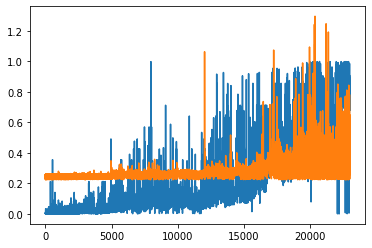

In [541]:
plt.plot(range(len(target)), target, range(len(predicted)), predicted)

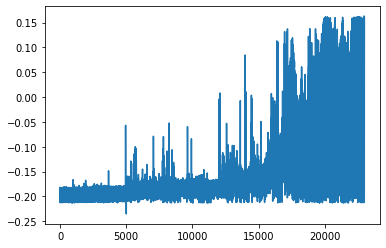

In [542]:
# negative = expected: flagged introduced higher price
plt.plot(range(len(diff)), diff)